Using the insurance claims dataset (dataset attached in the deck included in the deliverable), fit a logistic regression model in order to predict whether a fraud is reported or not?

Following are some of the description of key features:

* Customer Features: months_as_customer and age
    * months_as_customer: How long the customer has been as a customer OR taken insurance
    * age: Age of the customer
* Policy Related features: policy_number, policy_bind_date, policy_state, policy_csl, policy_deductable, policy_annual_premium etc
    * policy_csl: Combined Single Limit (CSL): is a single number that describes the predetermined limit for the combined total of the Bodily Injury Liability coverage and Property Damage Liability coverage per occurrence or accident.
* Insurance Related Features / Insured person's details: umbrella_limit, insured_zip, insured_gender, insured_education_level, insured_occupation, insured_hobbies
    * umbrella_limit: Set your umbrella limit based on your total assets. That gives you more protection than basing it on your net worth. Experts recommend coverage equal to the value of your assets without regard for your debts. This could help you avoid selling your home to pay a judgment if your net worth is your home equity. Umbrella insurance is extra insurance that provides protection beyond existing limits and coverages of other policies. Umbrella insurance can provide coverage for injuries, property damage, certain lawsuits, and personal liability situations.
* Incident Related features
* Claim Amount Related features
* [TARGET] Fraud Reported or not: YES / NO

a) Perform EDA and Feature Engineering as you can
b) Fit Logistic Regression Model and generate predictions
c) Ensure that your fitted model does not violate any of the LR assumptions

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.api import Logit, add_constant

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
# Load data
ins_clms = pd.read_csv('insurance_claims.csv')
ins_clms.sample(6)

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_gender,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
566,143,30,250249,28-11-1991,IN,100/300,500,1392.39,5000000,436499,FEMALE,High School,exec-managerial,dancing,unmarried,0,-65700,12-01-2015,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,SC,Riverwood,3323 1st Lane,16,1,NO,2,0,YES,54300,10860,5430,38010,Toyota,Highlander,2010,N
730,116,31,615116,09-11-2008,IN,250/500,500,1194.83,0,603733,FEMALE,MD,prof-specialty,camping,husband,28600,0,20-01-2015,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Riverwood,2037 5th Drive,23,1,NO,0,0,NO,44200,4420,8840,30940,Suburu,Forrestor,1997,N
71,222,41,260845,11-11-1998,OH,100/300,2000,1055.53,0,441992,FEMALE,MD,armed-forces,cross-fit,not-in-family,37800,-50300,08-02-2015,Single Vehicle Collision,Front Collision,Total Loss,Other,WV,Northbrook,6751 Pine Ridge,7,1,NO,0,2,NO,61290,6810,6810,47670,Honda,Civic,1995,Y
424,150,31,651948,28-09-1994,IN,500/1000,1000,1354.50,0,456602,MALE,Masters,machine-op-inspct,base-jumping,husband,52800,0,02-01-2015,Multi-vehicle Collision,Front Collision,Major Damage,Ambulance,NY,Arlington,6838 Flute Lane,6,3,?,0,3,YES,64800,6480,12960,45360,Suburu,Forrestor,2000,Y
837,9,24,326180,25-05-2002,IL,100/300,2000,1304.46,0,473349,FEMALE,PhD,machine-op-inspct,golf,other-relative,51700,-33300,31-01-2015,Vehicle Theft,?,Trivial Damage,None,NC,Arlington,6939 3rd Hwy,6,1,NO,0,3,YES,5940,540,1080,4320,Audi,A5,2001,Y
707,152,33,626208,08-05-2005,OH,100/300,1000,840.81,0,613607,FEMALE,High School,farming-fishing,chess,husband,0,0,14-02-2015,Single Vehicle Collision,Rear Collision,Minor Damage,Ambulance,NY,Arlington,4876 Washington Drive,2,1,YES,0,2,?,82610,7510,7510,67590,Ford,Escape,2002,Y


In [3]:
# Check info
ins_clms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
months_as_customer             1000 non-null int64
age                            1000 non-null int64
policy_number                  1000 non-null int64
policy_bind_date               1000 non-null object
policy_state                   1000 non-null object
policy_csl                     1000 non-null object
policy_deductable              1000 non-null int64
policy_annual_premium          1000 non-null float64
umbrella_limit                 1000 non-null int64
insured_zip                    1000 non-null int64
insured_gender                 1000 non-null object
insured_education_level        1000 non-null object
insured_occupation             1000 non-null object
insured_hobbies                1000 non-null object
insured_relationship           1000 non-null object
capital-gains                  1000 non-null int64
capital-loss                   1000 non-null int64
incident_date    

In [4]:
# Check missing values
ins_clms.isnull().sum()

months_as_customer             0
age                            0
policy_number                  0
policy_bind_date               0
policy_state                   0
policy_csl                     0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
insured_gender                 0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
capital-gains                  0
capital-loss                   0
incident_date                  0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_city                  0
incident_location              0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witnesses                      0
police_rep

In [5]:
# Lets look at top 10 customers who were associated with insurance company for a long time
(ins_clms['months_as_customer'].sort_values(ascending=False)//12).head(10)

514    39
891    39
538    39
67     39
780    39
353    39
714    39
15     39
588    39
203    39
Name: months_as_customer, dtype: int64

There are customers who have purchased policies with insurance company and have been associated with the insurer for more than 35 years

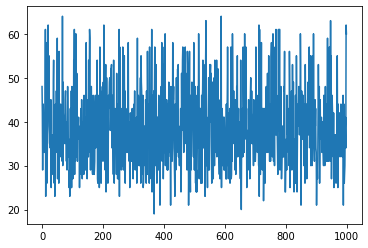

In [6]:
# Lets check customer Age
sns.lineplot(data=ins_clms['age'])
plt.show()

It can be seen that that there is no specific pattern here.

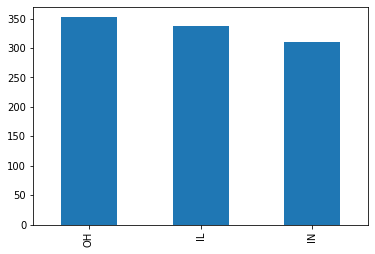

In [7]:
# Lets check Policy State
ins_clms['policy_state'].value_counts().plot(kind='bar')

Most of the policies belong to State of Ohio in US

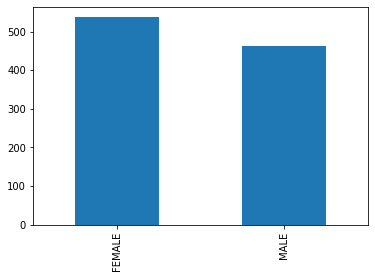

In [8]:
# Lets look at gender
ins_clms['insured_gender'].value_counts().plot(kind='bar')

Female policy holders are more than Male.

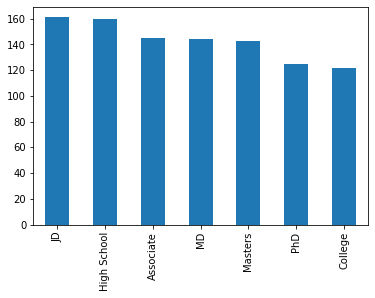

In [9]:
# Lets look at Education Level
ins_clms['insured_education_level'].value_counts().plot(kind='bar')

In [10]:
# Lets look at Top 10 policyholders with highest total claim amount
ins_clms.sort_values('total_claim_amount',ascending=False)[['total_claim_amount','insured_occupation','insured_relationship']].head(10)

,total_claim_amount,insured_occupation,insured_relationship
11,114920,exec-managerial,other-relative
149,112320,craft-repair,not-in-family
996,108480,prof-specialty,wife
565,108030,exec-managerial,not-in-family
163,107900,prof-specialty,not-in-family
718,105820,exec-managerial,husband
733,105040,craft-repair,wife
479,104610,sales,other-relative
458,103560,priv-house-serv,unmarried
189,101860,adm-clerical,other-relative


In [11]:
# Lets check if total_claim_amount = injury_claim + property_claim + vehicle_claim
total_clm = ins_clms['injury_claim'] + ins_clms['property_claim'] + ins_clms['vehicle_claim'] == ins_clms['total_claim_amount']
total_clm.unique()

array([ True])

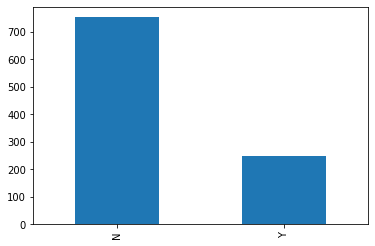

In [12]:
# Lets check fraud_reported
ins_clms['fraud_reported'].value_counts().plot(kind='bar')

Out of 1000 entries, 200 cases are where fraud is reported and the rest where there was no fraud reported

In [13]:
# Lets look at Categorical variables
cat_var = ['policy_state','policy_csl','insured_gender','insured_education_level','insured_occupation',
           'insured_hobbies','insured_relationship','incident_type','collision_type','incident_severity',
           'authorities_contacted','incident_state','incident_city','incident_location','property_damage',
           'police_report_available','auto_make','auto_model','fraud_reported']

for var in cat_var:
    print(ins_clms[var].value_counts(normalize=True)*100)
    print()

OH    35.2
IL    33.8
IN    31.0
Name: policy_state, dtype: float64

250/500     35.1
100/300     34.9
500/1000    30.0
Name: policy_csl, dtype: float64

FEMALE    53.7
MALE      46.3
Name: insured_gender, dtype: float64

JD             16.1
High School    16.0
Associate      14.5
MD             14.4
Masters        14.3
PhD            12.5
College        12.2
Name: insured_education_level, dtype: float64

machine-op-inspct    9.3
prof-specialty       8.5
tech-support         7.8
exec-managerial      7.6
sales                7.6
craft-repair         7.4
transport-moving     7.2
priv-house-serv      7.1
other-service        7.1
armed-forces         6.9
adm-clerical         6.5
protective-serv      6.3
handlers-cleaners    5.4
farming-fishing      5.3
Name: insured_occupation, dtype: float64

reading           6.4
paintball         5.7
exercise          5.7
bungie-jumping    5.6
camping           5.5
golf              5.5
movies            5.5
kayaking          5.4
yachting          5.3
h

In [14]:
# Lets drop insured_occupation, insured_hobbies, incident_location, auto_make, auto_model 
# as these variables have very few categotries
ins_clms.drop(['insured_occupation','insured_hobbies','incident_location','auto_make','auto_model'], axis=1, inplace=True)

In [15]:
# Replace varibales with few categories as Others
ins_clms['incident_type'] = ins_clms['incident_type'].replace(['Vehicle Theft','Parked Car'],'Others')
ins_clms['incident_state'] = ins_clms['incident_state'].replace(['PA','OH'],'Others')

# Replace ? with unknown
ins_clms['collision_type'] = ins_clms['collision_type'].replace('?','Unknown')
ins_clms['property_damage'] = ins_clms['property_damage'].replace('?','Unknown')
ins_clms['police_report_available'] = ins_clms['police_report_available'].replace('?','Unknown')

In [16]:
# Drop Policy Number as it is unique
ins_clms.drop('policy_number', axis=1, inplace=True)

# Drop policy_bind_date, incident_date (this is not time series data)
ins_clms.drop(['policy_bind_date','incident_date'], axis=1, inplace=True)

# Drop insured_zip (this has too many categories)
ins_clms.drop('insured_zip', axis=1, inplace=True)

In [17]:
# Lets check data frame
ins_clms.sample(10)

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_gender,insured_education_level,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,fraud_reported
573,402,54,OH,250/500,2000,1285.09,0,MALE,JD,not-in-family,48000,-79600,Single Vehicle Collision,Rear Collision,Major Damage,Other,NY,Springfield,19,1,NO,0,2,YES,67770,7530,15060,45180,2013,Y
819,356,47,IN,250/500,2000,1155.97,0,MALE,High School,husband,0,0,Single Vehicle Collision,Side Collision,Minor Damage,Other,SC,Columbus,5,1,YES,0,3,Unknown,61490,5590,11180,44720,2009,N
830,148,36,IL,500/1000,1000,1236.32,5000000,FEMALE,MD,own-child,55100,0,Single Vehicle Collision,Side Collision,Total Loss,Police,Others,Northbrook,0,1,NO,2,0,NO,61050,5550,11100,44400,2009,N
203,468,62,IL,100/300,500,1011.92,0,MALE,PhD,wife,0,0,Multi-vehicle Collision,Rear Collision,Major Damage,Fire,SC,Riverwood,7,3,YES,0,3,Unknown,64350,7150,7150,50050,2009,N
923,90,31,OH,250/500,2000,951.27,0,FEMALE,PhD,not-in-family,42100,0,Single Vehicle Collision,Rear Collision,Total Loss,Other,SC,Hillsdale,2,1,YES,1,0,YES,75790,13780,6890,55120,2007,N
79,227,38,OH,500/1000,500,976.67,0,FEMALE,PhD,unmarried,0,0,Single Vehicle Collision,Rear Collision,Major Damage,Fire,SC,Northbrook,16,1,Unknown,1,2,Unknown,72200,14440,7220,50540,2013,Y
906,225,43,OH,100/300,1000,1517.54,0,MALE,JD,own-child,0,-20900,Multi-vehicle Collision,Rear Collision,Major Damage,Police,SC,Columbus,16,3,NO,2,0,YES,64400,6440,6440,51520,2011,N
868,242,44,IL,500/1000,2000,1396.89,6000000,FEMALE,College,other-relative,0,-61600,Multi-vehicle Collision,Front Collision,Minor Damage,Other,SC,Springfield,15,3,NO,1,2,YES,66900,6690,13380,46830,1999,Y
425,4,34,OH,500/1000,500,1282.93,0,FEMALE,College,other-relative,0,0,Multi-vehicle Collision,Side Collision,Major Damage,Police,WV,Northbrook,0,4,Unknown,0,0,Unknown,66880,6080,12160,48640,1996,Y
483,222,40,IL,100/300,1000,1226.78,0,MALE,JD,unmarried,49600,-49200,Multi-vehicle Collision,Rear Collision,Minor Damage,Other,NY,Springfield,17,2,YES,2,0,Unknown,81500,16300,8150,57050,2013,N


In [18]:
# Dummy variables
pol_st_dummy = pd.get_dummies(ins_clms['policy_state'], prefix='polst', drop_first=True)
pol_csl_dummy = pd.get_dummies(ins_clms['policy_csl'], prefix='polcsl' ,drop_first=True)
ins_gender_dummy = pd.get_dummies(ins_clms['insured_gender'], drop_first=True)
ins_edulev_dummy = pd.get_dummies(ins_clms['insured_education_level'], drop_first=True)
ins_rltn_dummy = pd.get_dummies(ins_clms['insured_relationship'], drop_first=True)
inc_type_dummy = pd.get_dummies(ins_clms['incident_type'], prefix='inctyp' ,drop_first=True)
coll_type_dummy = pd.get_dummies(ins_clms['collision_type'], prefix='colltyp' ,drop_first=True)
inc_sev_dummy = pd.get_dummies(ins_clms['incident_severity'], prefix='incsev' ,drop_first=True)
auth_con_dummy = pd.get_dummies(ins_clms['authorities_contacted'], prefix='authcon',drop_first=True)
inc_st_dummy = pd.get_dummies(ins_clms['incident_state'], prefix='incst',drop_first=True)
inc_cty_dummy = pd.get_dummies(ins_clms['incident_city'], prefix='inccty' ,drop_first=True)
prop_dmg_dummy = pd.get_dummies(ins_clms['property_damage'], prefix='propdmg' ,drop_first=True)
pol_rep_dummy = pd.get_dummies(ins_clms['police_report_available'], prefix='polrep' ,drop_first=True)

In [19]:
# Merge with data frame
ins_clms = pd.concat([pol_st_dummy,pol_csl_dummy,ins_gender_dummy,ins_edulev_dummy,ins_rltn_dummy,inc_type_dummy,
                      coll_type_dummy,inc_sev_dummy,auth_con_dummy,inc_st_dummy,inc_cty_dummy,prop_dmg_dummy,
                      pol_rep_dummy,ins_clms], axis=1)

In [20]:
# Drop columns
ins_clms.drop(['policy_state','policy_csl','insured_gender','insured_education_level','insured_relationship',
               'incident_type','collision_type','incident_severity','authorities_contacted','incident_state',
               'incident_city','property_damage','police_report_available'], axis=1, inplace=True)

In [21]:
# Check data
ins_clms.sample(5)

,polst_IN,polst_OH,polcsl_250/500,polcsl_500/1000,MALE,College,High School,JD,MD,Masters,PhD,not-in-family,other-relative,own-child,unmarried,wife,inctyp_Others,inctyp_Single Vehicle Collision,colltyp_Rear Collision,colltyp_Side Collision,colltyp_Unknown,incsev_Minor Damage,incsev_Total Loss,incsev_Trivial Damage,authcon_Fire,authcon_None,authcon_Other,authcon_Police,incst_NY,incst_Others,incst_SC,incst_VA,incst_WV,inccty_Columbus,inccty_Hillsdale,inccty_Northbend,inccty_Northbrook,inccty_Riverwood,inccty_Springfield,propdmg_Unknown,propdmg_YES,polrep_Unknown,polrep_YES,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,fraud_reported
849,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,380,53,2000,1166.62,6000000,0,0,23,1,0,3,5700,570,570,4560,2001,N
392,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,160,36,1000,1118.58,0,0,-36600,5,3,2,1,51700,5170,10340,36190,2003,N
457,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,123,28,2000,1836.02,0,38000,-41200,5,1,2,1,79800,13300,6650,59850,2011,Y
496,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,321,44,2000,1344.56,6000000,0,-39100,7,1,1,2,4680,520,0,4160,1999,N
954,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,246,39,1000,1416.08,0,0,-36600,16,1,0,3,45180,5020,5020,35140,2004,N


In [22]:
# Drop auto_year as this indicates the year in which the vheicle is bought and may
# not be useful in predicting fraud
ins_clms.drop('auto_year', axis=1, inplace=True)

In [23]:
# Map Y and N to 1 and 0 for target
ins_clms['fraud_reported'] = ins_clms['fraud_reported'].map({'Y':1, 'N':0})

In [24]:
# Check data
ins_clms.sample(5)

,polst_IN,polst_OH,polcsl_250/500,polcsl_500/1000,MALE,College,High School,JD,MD,Masters,PhD,not-in-family,other-relative,own-child,unmarried,wife,inctyp_Others,inctyp_Single Vehicle Collision,colltyp_Rear Collision,colltyp_Side Collision,colltyp_Unknown,incsev_Minor Damage,incsev_Total Loss,incsev_Trivial Damage,authcon_Fire,authcon_None,authcon_Other,authcon_Police,incst_NY,incst_Others,incst_SC,incst_VA,incst_WV,inccty_Columbus,inccty_Hillsdale,inccty_Northbend,inccty_Northbrook,inccty_Riverwood,inccty_Springfield,propdmg_Unknown,propdmg_YES,polrep_Unknown,polrep_YES,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,fraud_reported
76,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,270,45,1000,1038.09,0,0,-19700,18,3,1,1,89400,14900,7450,67050,0
461,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,410,54,2000,714.03,0,0,-17000,0,1,0,2,59520,9920,9920,39680,0
532,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,169,38,1000,1555.94,0,23300,0,12,3,1,3,79080,6590,13180,59310,0
41,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,116,34,500,1737.66,0,0,-24100,1,1,1,1,97080,16180,16180,64720,1
662,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,211,37,2000,1295.63,4000000,42200,-33800,22,3,1,0,53460,5940,5940,41580,0


In [25]:
# Check correlation
X = ins_clms[['months_as_customer','age','policy_deductable','policy_annual_premium','umbrella_limit','capital-gains',
     'capital-loss','incident_hour_of_the_day','number_of_vehicles_involved','bodily_injuries',
     'witnesses','total_claim_amount','injury_claim','property_claim','vehicle_claim']]
X.corr()

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim
months_as_customer,1.000000,0.922098,0.026807,0.005018,0.015498,0.006399,0.020209,0.070639,0.014736,-0.010162,0.058383,0.062108,0.065329,0.034940,0.061013
age,0.922098,1.000000,0.029188,0.014404,0.018126,-0.007075,0.007368,0.087161,0.022102,-0.015679,0.052359,0.069863,0.075522,0.060898,0.062588
policy_deductable,0.026807,0.029188,1.000000,-0.003245,0.010870,0.035212,-0.023544,0.060935,0.051214,-0.022765,0.066639,0.022839,0.039107,0.064792,0.005269
policy_annual_premium,0.005018,0.014404,-0.003245,1.000000,-0.006247,-0.013738,0.023547,-0.001578,-0.045991,0.026780,0.002332,0.009094,-0.017633,-0.011654,0.020246
umbrella_limit,0.015498,0.018126,0.010870,-0.006247,1.000000,-0.047268,-0.024056,-0.023257,-0.021270,0.022743,-0.006738,-0.040344,-0.045412,-0.023790,-0.038584
capital-gains,0.006399,-0.007075,0.035212,-0.013738,-0.047268,1.000000,-0.046904,-0.016406,0.061643,0.055829,-0.017651,0.015980,0.025934,-0.000779,0.015836
capital-loss,0.020209,0.007368,-0.023544,0.023547,-0.024056,-0.046904,1.000000,-0.025054,-0.014895,-0.024418,-0.041330,-0.036060,-0.046060,-0.022863,-0.032665
incident_hour_of_the_day,0.070639,0.087161,0.060935,-0.001578,-0.023257,-0.016406,-0.025054,1.000000,0.120794,-0.034563,0.006527,0.217702,0.165768,0.179536,0.215626
number_of_vehicles_involved,0.014736,0.022102,0.051214,-0.045991,-0.021270,0.061643,-0.014895,0.120794,1.000000,0.014030,-0.014669,0.274278,0.224650,0.219084,0.269393
bodily_injuries,-0.010162,-0.015679,-0.022765,0.026780,0.022743,0.055829,-0.024418,-0.034563,0.014030,1.000000,-0.005606,0.047093,0.047319,0.039749,0.043449


**Do not see strong correlation except for the case months_as_customer and age**

In [26]:
# Lets check correlation with y
y = ins_clms['fraud_reported']
X.corrwith(y)

months_as_customer             0.020544
age                            0.012143
policy_deductable              0.014817
policy_annual_premium         -0.014480
umbrella_limit                 0.058622
capital-gains                 -0.019173
capital-loss                  -0.014863
incident_hour_of_the_day       0.004316
number_of_vehicles_involved    0.051839
bodily_injuries                0.033877
witnesses                      0.049497
total_claim_amount             0.163651
injury_claim                   0.090975
property_claim                 0.137835
vehicle_claim                  0.170049
dtype: float64

In [27]:
# Lets check multi-collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

months_as_customer             18.374090
age                            65.889481
policy_deductable               4.421654
policy_annual_premium          19.994994
umbrella_limit                  1.235073
capital-gains                   1.821686
capital-loss                    1.920120
incident_hour_of_the_day        4.040036
number_of_vehicles_involved     4.577519
bodily_injuries                 2.455081
witnesses                       2.801968
total_claim_amount                   inf
injury_claim                         inf
property_claim                       inf
vehicle_claim                        inf
dtype: float64

In [28]:
# There are variables VIF infinity, but these variables indicate moderate correlation with y compared to others
# Lets retain these variables as is, and start dropping age first
X.drop('age', axis=1, inplace=True)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

months_as_customer              3.998604
policy_deductable               4.300216
policy_annual_premium          11.074566
umbrella_limit                  1.229436
capital-gains                   1.815730
capital-loss                    1.896469
incident_hour_of_the_day        3.953186
number_of_vehicles_involved     4.463838
bodily_injuries                 2.432870
witnesses                       2.766590
total_claim_amount                   inf
injury_claim                         inf
property_claim                       inf
vehicle_claim                        inf
dtype: float64

In [29]:
# Lets drop policy_annual_premium
X.drop('policy_annual_premium', axis=1, inplace=True)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

months_as_customer             3.679256
policy_deductable              3.903380
umbrella_limit                 1.218696
capital-gains                  1.788837
capital-loss                   1.868560
incident_hour_of_the_day       3.800622
number_of_vehicles_involved    4.318692
bodily_injuries                2.299335
witnesses                      2.627490
total_claim_amount                  inf
injury_claim                        inf
property_claim                      inf
vehicle_claim                       inf
dtype: float64

In [30]:
# VIFs came down below 5, except for cases where it is infinity
# Now we can drop those with inf one by one,
# Lets choose one with lowest correlation injury_claim
X.drop('injury_claim', axis=1, inplace=True)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

months_as_customer               3.679256
policy_deductable                3.903380
umbrella_limit                   1.218696
capital-gains                    1.788837
capital-loss                     1.868560
incident_hour_of_the_day         3.800622
number_of_vehicles_involved      4.318692
bodily_injuries                  2.299335
witnesses                        2.627490
total_claim_amount             310.136152
property_claim                  15.388394
vehicle_claim                  229.056975
dtype: float64

In [31]:
# We can see now VIFs reduced drastically from infinity
# Now lets drop propert_claim due to low correlation
X.drop('property_claim', axis=1, inplace=True)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

months_as_customer               3.670036
policy_deductable                3.901709
umbrella_limit                   1.218094
capital-gains                    1.787468
capital-loss                     1.866531
incident_hour_of_the_day         3.800232
number_of_vehicles_involved      4.318029
bodily_injuries                  2.299076
witnesses                        2.608812
total_claim_amount             148.246459
vehicle_claim                  147.445476
dtype: float64

In [32]:
# Lets drop total_claim_amount due to low correlation
X.drop('total_claim_amount', axis=1, inplace=True)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

months_as_customer             3.669187
policy_deductable              3.881233
umbrella_limit                 1.217521
capital-gains                  1.787068
capital-loss                   1.866445
incident_hour_of_the_day       3.799908
number_of_vehicles_involved    4.313035
bodily_injuries                2.298727
witnesses                      2.604886
vehicle_claim                  5.185790
dtype: float64

**VIFs have come down below 5, except vehicle_claim. Lets proceed with fitting the model, and check which variables are significant**

In [33]:
# Lets split the data into train and test
from sklearn.model_selection import train_test_split

X = ins_clms.drop(['age','policy_annual_premium','injury_claim',
                   'property_claim','total_claim_amount','fraud_reported'], axis=1)
y =  ins_clms['fraud_reported']

In [34]:
# Lets check X
X.head()

,polst_IN,polst_OH,polcsl_250/500,polcsl_500/1000,MALE,College,High School,JD,MD,Masters,PhD,not-in-family,other-relative,own-child,unmarried,wife,inctyp_Others,inctyp_Single Vehicle Collision,colltyp_Rear Collision,colltyp_Side Collision,colltyp_Unknown,incsev_Minor Damage,incsev_Total Loss,incsev_Trivial Damage,authcon_Fire,authcon_None,authcon_Other,authcon_Police,incst_NY,incst_Others,incst_SC,incst_VA,incst_WV,inccty_Columbus,inccty_Hillsdale,inccty_Northbend,inccty_Northbrook,inccty_Riverwood,inccty_Springfield,propdmg_Unknown,propdmg_YES,polrep_Unknown,polrep_YES,months_as_customer,policy_deductable,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,vehicle_claim
0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,328,1000,0,53300,0,5,1,1,2,52080
1,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,228,2000,5000000,0,0,8,1,0,0,3510
2,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,134,2000,5000000,35100,0,7,3,2,3,23100
3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,256,2000,6000000,48900,-62400,5,1,1,2,50720
4,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,228,1000,6000000,66000,-46000,20,1,0,1,4550


In [35]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [36]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

In [37]:
# Scale the data
scaler = StandardScaler()

num_var = ['months_as_customer','policy_deductable','umbrella_limit','capital-gains',
           'capital-loss','incident_hour_of_the_day','number_of_vehicles_involved',
           'bodily_injuries','witnesses','vehicle_claim']

X_train[num_var] = scaler.fit_transform(X_train[num_var])
X_test[num_var] = scaler.transform(X_test[num_var])

In [38]:
# Train the model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      647
Model Family:                Binomial   Df Model:                           52
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -249.12
Date:                Thu, 23 Mar 2023   Deviance:                       498.25
Time:                        13:41:40   Pearson chi2:                     747.
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.6932      1.037     -0.668      0.504      -2.726       1.339
polst_IN                            0.0155      0.299      0.052      0.959      -0.571       0.602
polst_OH                            0.2701      0.291      0.927      0.354      -0.301       0.841
polcsl_250/500                      0.5793      0.284      2.041      0.041       0.023       1.136
polcsl_500/1000                    -0.0640      0.308     -0.207      0.836      -0.668       0.540
MALE                                0.3443      0.238      1.450      0.147      -0.121       0.810
College                             0.4214      0.480      0.878      0.380      -0.520       1.362
High School                         1.1486      0.447      2.568      0.010       0.272       2.025
JD                                  1.1158      0.437      2.554      0.011       0.260       1.972
MD                                  0.1789      0.462      0.387      0.699      -0.727       1.085
Masters                             0.5067      0.469      1.081      0.280      -0.412       1.425
PhD                                 0.2453      0.490      0.501      0.617      -0.715       1.205
not-in-family                       1.1039      0.424      2.602      0.009       0.272       1.935
other-relative                      0.6958      0.409      1.702      0.089      -0.105       1.497
own-child                          -0.3157      0.428     -0.738      0.460      -1.154       0.523
unmarried                           0.5825      0.430      1.354      0.176      -0.261       1.426
wife                                0.3366      0.422      0.798      0.425      -0.491       1.164
inctyp_Others                       1.0553      0.683      1.545      0.122      -0.284       2.394
inctyp_Single Vehicle Collision     1.4514      1.081      1.343      0.179      -0.667       3.570
colltyp_Rear Collision             -0.1089      0.316     -0.344      0.731      -0.729       0.511
colltyp_Side Collision             -0.4550      0.326     -1.395      0.163      -1.094       0.184
colltyp_Unknown                     1.0553      0.683      1.545      0.122      -0.284       2.394
incsev_Minor Damage                -3.4138      0.362     -9.419      0.000      -4.124      -2.703
incsev_Total Loss                  -3.0390      0.325     -9.365      0.000      -3.675      -2.403
incsev_Trivial Damage              -5.8367      1.034     -5.647      0.000      -7.862      -3.811
authcon_Fire                       -0.2973      0.352     -0.844      0.399      -0.988       0.393
authcon_None                       -1.6748      0.901     -1.858      0.063      -3.442       0.092
authcon_Other                       0.1788      0.361      0.495      0.621      -0

In [39]:
# Lets drop variables with highest p-value one by one
# Lets drop polst_IN
X_train.drop('polst_IN', axis=1, inplace=True)
X_test.drop('polst_IN', axis=1, inplace=True)

In [40]:
# Train the model
logm2 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      648
Model Family:                Binomial   Df Model:                           51
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -249.12
Date:                Thu, 23 Mar 2023   Deviance:                       498.25
Time:                        13:42:26   Pearson chi2:                     744.
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.6834      1.016     -0.673      0.501      -2.674       1.308
polst_OH                            0.2623      0.248      1.057      0.290      -0.224       0.749
polcsl_250/500                      0.5788      0.283      2.042      0.041       0.023       1.134
polcsl_500/1000                    -0.0635      0.307     -0.207      0.836      -0.666       0.539
MALE                                0.3436      0.237      1.452      0.147      -0.120       0.808
College                             0.4200      0.477      0.881      0.378      -0.515       1.354
High School                         1.1463      0.444      2.581      0.010       0.276       2.017
JD                                  1.1153      0.433      2.579      0.010       0.268       1.963
MD                                  0.1791      0.458      0.391      0.696      -0.719       1.077
Masters                             0.5042      0.464      1.086      0.277      -0.406       1.414
PhD                                 0.2436      0.488      0.500      0.617      -0.712       1.199
not-in-family                       1.1025      0.424      2.599      0.009       0.271       1.934
other-relative                      0.6943      0.408      1.701      0.089      -0.106       1.494
own-child                          -0.3164      0.427     -0.741      0.459      -1.153       0.521
unmarried                           0.5816      0.431      1.350      0.177      -0.263       1.426
wife                                0.3360      0.422      0.796      0.426      -0.491       1.163
inctyp_Others                       1.0564      0.682      1.550      0.121      -0.279       2.392
inctyp_Single Vehicle Collision     1.4534      1.077      1.350      0.177      -0.657       3.564
colltyp_Rear Collision             -0.1102      0.314     -0.351      0.726      -0.725       0.505
colltyp_Side Collision             -0.4551      0.326     -1.397      0.162      -1.094       0.183
colltyp_Unknown                     1.0564      0.682      1.550      0.121      -0.279       2.392
incsev_Minor Damage                -3.4126      0.360     -9.482      0.000      -4.118      -2.707
incsev_Total Loss                  -3.0375      0.322     -9.427      0.000      -3.669      -2.406
incsev_Trivial Damage              -5.8350      1.007     -5.792      0.000      -7.809      -3.861
authcon_Fire                       -0.2976      0.351     -0.848      0.396      -0.985       0.390
authcon_None                       -1.6714      0.889     -1.881      0.060      -3.413       0.070
authcon_Other                       0.1778      0.360      0.495      0.621      -0.527       0.883
authcon_Police                      0.2339      0.362      0.646      0.519      -0

In [41]:
# Lets drop vehicle_claim
X_train.drop('vehicle_claim', axis=1, inplace=True)
X_test.drop('vehicle_claim', axis=1, inplace=True)

In [42]:
# Train the model
logm3 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm3.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      649
Model Family:                Binomial   Df Model:                           50
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -249.13
Date:                Thu, 23 Mar 2023   Deviance:                       498.26
Time:                        13:43:08   Pearson chi2:                     749.
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.6935      1.012     -0.685      0.493      -2.678       1.291
polst_OH                            0.2624      0.249      1.055      0.291      -0.225       0.750
polcsl_250/500                      0.5794      0.284      2.041      0.041       0.023       1.136
polcsl_500/1000                    -0.0649      0.308     -0.211      0.833      -0.669       0.539
MALE                                0.3448      0.237      1.456      0.145      -0.119       0.809
College                             0.4253      0.476      0.893      0.372      -0.508       1.359
High School                         1.1477      0.446      2.571      0.010       0.273       2.023
JD                                  1.1189      0.435      2.571      0.010       0.266       1.972
MD                                  0.1817      0.461      0.394      0.694      -0.722       1.085
Masters                             0.5060      0.467      1.084      0.278      -0.409       1.420
PhD                                 0.2457      0.489      0.503      0.615      -0.713       1.204
not-in-family                       1.1031      0.424      2.602      0.009       0.272       1.934
other-relative                      0.6946      0.408      1.701      0.089      -0.106       1.495
own-child                          -0.3181      0.427     -0.745      0.456      -1.155       0.519
unmarried                           0.5816      0.430      1.352      0.176      -0.261       1.425
wife                                0.3349      0.422      0.794      0.427      -0.491       1.161
inctyp_Others                       1.0789      0.622      1.734      0.083      -0.140       2.298
inctyp_Single Vehicle Collision     1.4536      1.080      1.346      0.178      -0.663       3.570
colltyp_Rear Collision             -0.1078      0.313     -0.344      0.731      -0.721       0.506
colltyp_Side Collision             -0.4540      0.326     -1.394      0.163      -1.093       0.185
colltyp_Unknown                     1.0789      0.622      1.734      0.083      -0.140       2.298
incsev_Minor Damage                -3.4145      0.362     -9.434      0.000      -4.124      -2.705
incsev_Total Loss                  -3.0373      0.323     -9.395      0.000      -3.671      -2.404
incsev_Trivial Damage              -5.8419      1.029     -5.676      0.000      -7.859      -3.825
authcon_Fire                       -0.3000      0.351     -0.854      0.393      -0.988       0.388
authcon_None                       -1.6788      0.899     -1.868      0.062      -3.440       0.082
authcon_Other                       0.1734      0.356      0.487      0.626      -0.524       0.871
authcon_Police                      0.2296      0.358      0.641      0.521      -0

In [43]:
# Lets drop capital-loss
X_train.drop('capital-loss', axis=1, inplace=True)
X_test.drop('capital-loss', axis=1, inplace=True)

In [44]:
# Train the model
logm4 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      650
Model Family:                Binomial   Df Model:                           49
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -249.15
Date:                Thu, 23 Mar 2023   Deviance:                       498.30
Time:                        13:44:01   Pearson chi2:                     748.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.6817      1.010     -0.675      0.500      -2.662       1.299
polst_OH                            0.2629      0.249      1.057      0.290      -0.224       0.750
polcsl_250/500                      0.5783      0.284      2.038      0.042       0.022       1.134
polcsl_500/1000                    -0.0641      0.308     -0.208      0.835      -0.668       0.540
MALE                                0.3448      0.237      1.456      0.145      -0.119       0.809
College                             0.4269      0.476      0.896      0.370      -0.507       1.360
High School                         1.1478      0.446      2.573      0.010       0.274       2.022
JD                                  1.1205      0.435      2.576      0.010       0.268       1.973
MD                                  0.1808      0.461      0.392      0.695      -0.722       1.084
Masters                             0.5031      0.466      1.079      0.280      -0.411       1.417
PhD                                 0.2436      0.489      0.499      0.618      -0.714       1.201
not-in-family                       1.1042      0.424      2.604      0.009       0.273       1.935
other-relative                      0.6966      0.408      1.707      0.088      -0.103       1.497
own-child                          -0.3119      0.426     -0.733      0.464      -1.146       0.523
unmarried                           0.5850      0.430      1.361      0.174      -0.258       1.428
wife                                0.3415      0.420      0.813      0.416      -0.482       1.165
inctyp_Others                       1.0733      0.621      1.728      0.084      -0.144       2.290
inctyp_Single Vehicle Collision     1.4383      1.076      1.336      0.181      -0.671       3.548
colltyp_Rear Collision             -0.1125      0.312     -0.361      0.718      -0.724       0.499
colltyp_Side Collision             -0.4604      0.324     -1.420      0.156      -1.096       0.175
colltyp_Unknown                     1.0733      0.621      1.728      0.084      -0.144       2.290
incsev_Minor Damage                -3.4122      0.362     -9.436      0.000      -4.121      -2.703
incsev_Total Loss                  -3.0326      0.322     -9.409      0.000      -3.664      -2.401
incsev_Trivial Damage              -5.8529      1.028     -5.694      0.000      -7.868      -3.838
authcon_Fire                       -0.3079      0.349     -0.883      0.377      -0.992       0.376
authcon_None                       -1.6912      0.896     -1.887      0.059      -3.448       0.066
authcon_Other                       0.1695      0.355      0.477      0.634      -0.527       0.866
authcon_Police                      0.2259      0.357      0.632      0.527      -0

In [45]:
# Lets drop incst_VA
X_train.drop('incst_VA', axis=1, inplace=True)
X_test.drop('incst_VA', axis=1, inplace=True)

In [46]:
# Train the model
logm5 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm5.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      651
Model Family:                Binomial   Df Model:                           48
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -249.17
Date:                Thu, 23 Mar 2023   Deviance:                       498.34
Time:                        13:45:05   Pearson chi2:                     745.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.6174      0.961     -0.643      0.520      -2.500       1.265
polst_OH                            0.2618      0.249      1.053      0.292      -0.225       0.749
polcsl_250/500                      0.5807      0.284      2.048      0.041       0.025       1.136
polcsl_500/1000                    -0.0610      0.308     -0.198      0.843      -0.664       0.542
MALE                                0.3437      0.237      1.451      0.147      -0.120       0.808
College                             0.4311      0.476      0.906      0.365      -0.501       1.364
High School                         1.1524      0.445      2.587      0.010       0.279       2.025
JD                                  1.1166      0.434      2.570      0.010       0.265       1.968
MD                                  0.1831      0.461      0.397      0.691      -0.720       1.086
Masters                             0.4939      0.464      1.064      0.287      -0.416       1.404
PhD                                 0.2442      0.489      0.500      0.617      -0.713       1.202
not-in-family                       1.1054      0.424      2.607      0.009       0.274       1.936
other-relative                      0.6917      0.407      1.698      0.090      -0.107       1.490
own-child                          -0.3185      0.425     -0.750      0.453      -1.151       0.514
unmarried                           0.5780      0.428      1.349      0.177      -0.262       1.418
wife                                0.3378      0.420      0.805      0.421      -0.485       1.161
inctyp_Others                       1.0614      0.618      1.718      0.086      -0.149       2.272
inctyp_Single Vehicle Collision     1.4127      1.068      1.322      0.186      -0.681       3.507
colltyp_Rear Collision             -0.1133      0.312     -0.363      0.717      -0.725       0.498
colltyp_Side Collision             -0.4624      0.324     -1.427      0.154      -1.097       0.173
colltyp_Unknown                     1.0614      0.618      1.718      0.086      -0.149       2.272
incsev_Minor Damage                -3.4130      0.361     -9.443      0.000      -4.121      -2.705
incsev_Total Loss                  -3.0316      0.322     -9.407      0.000      -3.663      -2.400
incsev_Trivial Damage              -5.8688      1.026     -5.720      0.000      -7.880      -3.858
authcon_Fire                       -0.3046      0.348     -0.874      0.382      -0.987       0.378
authcon_None                       -1.6842      0.895     -1.881      0.060      -3.439       0.071
authcon_Other                       0.1718      0.355      0.484      0.629      -0.524       0.868
authcon_Police                      0.2296      0.357      0.643      0.520      -0

In [47]:
# Lets drop polcsl_500/1000
X_train.drop('polcsl_500/1000', axis=1, inplace=True)
X_test.drop('polcsl_500/1000', axis=1, inplace=True)

In [48]:
# Train the model
logm6 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm6.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      652
Model Family:                Binomial   Df Model:                           47
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -249.19
Date:                Thu, 23 Mar 2023   Deviance:                       498.38
Time:                        13:45:52   Pearson chi2:                     745.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.6502      0.945     -0.688      0.492      -2.503       1.202
polst_OH                            0.2588      0.248      1.043      0.297      -0.228       0.745
polcsl_250/500                      0.6087      0.246      2.470      0.014       0.126       1.092
MALE                                0.3446      0.237      1.455      0.146      -0.120       0.809
College                             0.4399      0.474      0.928      0.353      -0.489       1.368
High School                         1.1569      0.445      2.600      0.009       0.285       2.029
JD                                  1.1241      0.433      2.597      0.009       0.276       1.973
MD                                  0.1893      0.460      0.412      0.680      -0.711       1.090
Masters                             0.4919      0.464      1.060      0.289      -0.418       1.401
PhD                                 0.2441      0.488      0.500      0.617      -0.713       1.201
not-in-family                       1.1079      0.424      2.613      0.009       0.277       1.939
other-relative                      0.6926      0.408      1.699      0.089      -0.106       1.492
own-child                          -0.3120      0.423     -0.737      0.461      -1.142       0.518
unmarried                           0.5775      0.428      1.348      0.178      -0.262       1.417
wife                                0.3438      0.419      0.820      0.412      -0.478       1.165
inctyp_Others                       1.0578      0.617      1.715      0.086      -0.151       2.266
inctyp_Single Vehicle Collision     1.4144      1.067      1.326      0.185      -0.676       3.505
colltyp_Rear Collision             -0.1123      0.312     -0.360      0.719      -0.724       0.499
colltyp_Side Collision             -0.4626      0.324     -1.428      0.153      -1.098       0.172
colltyp_Unknown                     1.0578      0.617      1.715      0.086      -0.151       2.266
incsev_Minor Damage                -3.4126      0.361     -9.447      0.000      -4.121      -2.705
incsev_Total Loss                  -3.0346      0.322     -9.425      0.000      -3.666      -2.404
incsev_Trivial Damage              -5.8603      1.025     -5.717      0.000      -7.869      -3.851
authcon_Fire                       -0.3077      0.348     -0.884      0.377      -0.990       0.374
authcon_None                       -1.6866      0.895     -1.884      0.060      -3.442       0.068
authcon_Other                       0.1663      0.354      0.470      0.639      -0.527       0.860
authcon_Police                      0.2253      0.357      0.632      0.527      -0.473       0.924
incst_NY                           -0.3134      0.329     -0.952      0.341      -0

In [49]:
# Lets drop colltyp_Rear Collision
X_train.drop('colltyp_Rear Collision', axis=1, inplace=True)
X_test.drop('colltyp_Rear Collision', axis=1, inplace=True)

In [50]:
# Train the model
logm7 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm7.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      653
Model Family:                Binomial   Df Model:                           46
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -249.25
Date:                Thu, 23 Mar 2023   Deviance:                       498.51
Time:                        13:46:37   Pearson chi2:                     744.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.7026      0.935     -0.752      0.452      -2.535       1.130
polst_OH                            0.2480      0.246      1.007      0.314      -0.235       0.731
polcsl_250/500                      0.6061      0.246      2.460      0.014       0.123       1.089
MALE                                0.3446      0.237      1.456      0.145      -0.119       0.808
College                             0.4464      0.474      0.942      0.346      -0.482       1.375
High School                         1.1660      0.445      2.623      0.009       0.295       2.037
JD                                  1.1271      0.433      2.603      0.009       0.278       1.976
MD                                  0.2082      0.457      0.456      0.649      -0.687       1.103
Masters                             0.5136      0.460      1.116      0.265      -0.389       1.416
PhD                                 0.2460      0.489      0.504      0.615      -0.712       1.204
not-in-family                       1.1036      0.424      2.605      0.009       0.273       1.934
other-relative                      0.6956      0.407      1.707      0.088      -0.103       1.494
own-child                          -0.3092      0.423     -0.730      0.465      -1.139       0.521
unmarried                           0.5701      0.428      1.332      0.183      -0.269       1.409
wife                                0.3476      0.419      0.830      0.407      -0.473       1.169
inctyp_Others                       1.0858      0.613      1.772      0.076      -0.115       2.287
inctyp_Single Vehicle Collision     1.3967      1.067      1.309      0.190      -0.694       3.487
colltyp_Side Collision             -0.3981      0.270     -1.475      0.140      -0.927       0.131
colltyp_Unknown                     1.0858      0.613      1.772      0.076      -0.115       2.287
incsev_Minor Damage                -3.4090      0.361     -9.452      0.000      -4.116      -2.702
incsev_Total Loss                  -3.0273      0.321     -9.431      0.000      -3.656      -2.398
incsev_Trivial Damage              -5.8513      1.025     -5.711      0.000      -7.859      -3.843
authcon_Fire                       -0.2979      0.347     -0.859      0.390      -0.978       0.382
authcon_None                       -1.7003      0.895     -1.900      0.057      -3.454       0.054
authcon_Other                       0.1660      0.354      0.469      0.639      -0.528       0.860
authcon_Police                      0.2122      0.355      0.598      0.550      -0.483       0.907
incst_NY                           -0.3129      0.329     -0.951      0.342      -0.958       0.332
incst_Others                        0.2931      0.548      0.535      0.592      -0

In [51]:
# Lets drop incident_hour_of_the_day
X_train.drop('incident_hour_of_the_day', axis=1, inplace=True)
X_test.drop('incident_hour_of_the_day', axis=1, inplace=True)

In [52]:
# Train the model
logm8 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm8.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      654
Model Family:                Binomial   Df Model:                           45
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -249.32
Date:                Thu, 23 Mar 2023   Deviance:                       498.64
Time:                        13:47:23   Pearson chi2:                     740.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.6859      0.933     -0.735      0.462      -2.515       1.143
polst_OH                            0.2425      0.246      0.987      0.324      -0.239       0.724
polcsl_250/500                      0.6057      0.246      2.460      0.014       0.123       1.088
MALE                                0.3417      0.236      1.445      0.148      -0.122       0.805
College                             0.4454      0.474      0.940      0.347      -0.483       1.374
High School                         1.1684      0.444      2.629      0.009       0.297       2.039
JD                                  1.1268      0.432      2.605      0.009       0.279       1.974
MD                                  0.2131      0.456      0.467      0.640      -0.681       1.107
Masters                             0.5187      0.460      1.128      0.259      -0.382       1.420
PhD                                 0.2477      0.488      0.507      0.612      -0.710       1.205
not-in-family                       1.0949      0.423      2.591      0.010       0.267       1.923
other-relative                      0.6911      0.407      1.696      0.090      -0.108       1.490
own-child                          -0.3168      0.423     -0.750      0.454      -1.145       0.512
unmarried                           0.5654      0.428      1.323      0.186      -0.273       1.403
wife                                0.3437      0.419      0.821      0.412      -0.477       1.164
inctyp_Others                       1.0801      0.612      1.763      0.078      -0.120       2.281
inctyp_Single Vehicle Collision     1.3723      1.064      1.290      0.197      -0.713       3.458
colltyp_Side Collision             -0.4078      0.269     -1.519      0.129      -0.934       0.119
colltyp_Unknown                     1.0801      0.612      1.763      0.078      -0.120       2.281
incsev_Minor Damage                -3.4061      0.360     -9.452      0.000      -4.112      -2.700
incsev_Total Loss                  -3.0301      0.321     -9.446      0.000      -3.659      -2.401
incsev_Trivial Damage              -5.8502      1.026     -5.703      0.000      -7.861      -3.840
authcon_Fire                       -0.3026      0.347     -0.873      0.383      -0.982       0.377
authcon_None                       -1.6824      0.894     -1.883      0.060      -3.434       0.069
authcon_Other                       0.1694      0.354      0.479      0.632      -0.524       0.863
authcon_Police                      0.2166      0.354      0.611      0.541      -0.478       0.911
incst_NY                           -0.3177      0.329     -0.967      0.334      -0.962       0.326
incst_Others                        0.3014      0.548      0.550      0.582      -0

In [53]:
# Lets drop witnesses
X_train.drop('witnesses', axis=1, inplace=True)
X_test.drop('witnesses', axis=1, inplace=True)

In [54]:
# Train the model
logm9 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm9.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      655
Model Family:                Binomial   Df Model:                           44
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -249.40
Date:                Thu, 23 Mar 2023   Deviance:                       498.80
Time:                        13:48:14   Pearson chi2:                     739.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.6680      0.932     -0.717      0.473      -2.494       1.158
polst_OH                            0.2456      0.246      1.000      0.317      -0.236       0.727
polcsl_250/500                      0.6068      0.246      2.466      0.014       0.125       1.089
MALE                                0.3446      0.236      1.458      0.145      -0.118       0.808
College                             0.4383      0.473      0.927      0.354      -0.488       1.365
High School                         1.1607      0.444      2.613      0.009       0.290       2.031
JD                                  1.1239      0.432      2.601      0.009       0.277       1.971
MD                                  0.2024      0.455      0.444      0.657      -0.690       1.095
Masters                             0.5298      0.459      1.154      0.249      -0.370       1.430
PhD                                 0.2411      0.488      0.494      0.621      -0.715       1.197
not-in-family                       1.0763      0.420      2.563      0.010       0.253       1.899
other-relative                      0.6894      0.407      1.693      0.090      -0.109       1.487
own-child                          -0.3195      0.422     -0.757      0.449      -1.147       0.508
unmarried                           0.5701      0.428      1.333      0.182      -0.268       1.408
wife                                0.3382      0.418      0.808      0.419      -0.482       1.158
inctyp_Others                       1.0668      0.611      1.747      0.081      -0.130       2.264
inctyp_Single Vehicle Collision     1.3428      1.060      1.267      0.205      -0.735       3.420
colltyp_Side Collision             -0.4099      0.269     -1.526      0.127      -0.936       0.117
colltyp_Unknown                     1.0668      0.611      1.747      0.081      -0.130       2.264
incsev_Minor Damage                -3.4137      0.360     -9.483      0.000      -4.119      -2.708
incsev_Total Loss                  -3.0383      0.320     -9.482      0.000      -3.666      -2.410
incsev_Trivial Damage              -5.8404      1.024     -5.702      0.000      -7.848      -3.833
authcon_Fire                       -0.2971      0.346     -0.859      0.391      -0.975       0.381
authcon_None                       -1.6745      0.892     -1.877      0.061      -3.423       0.074
authcon_Other                       0.1700      0.354      0.481      0.631      -0.523       0.863
authcon_Police                      0.2116      0.354      0.598      0.550      -0.482       0.905
incst_NY                           -0.3159      0.328     -0.962      0.336      -0.960       0.328
incst_Others                        0.3058      0.546      0.560      0.576      -0

In [55]:
# Lets drop polrep_Unknown
X_train.drop('polrep_Unknown', axis=1, inplace=True)
X_test.drop('polrep_Unknown', axis=1, inplace=True)

In [56]:
# Train the model
logm10 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm10.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      656
Model Family:                Binomial   Df Model:                           43
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -249.49
Date:                Thu, 23 Mar 2023   Deviance:                       498.99
Time:                        13:49:03   Pearson chi2:                     735.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.7582      0.908     -0.835      0.404      -2.538       1.021
polst_OH                            0.2537      0.245      1.036      0.300      -0.226       0.734
polcsl_250/500                      0.6150      0.245      2.506      0.012       0.134       1.096
MALE                                0.3486      0.236      1.477      0.140      -0.114       0.811
College                             0.4393      0.473      0.928      0.353      -0.488       1.367
High School                         1.1687      0.444      2.632      0.008       0.298       2.039
JD                                  1.1217      0.432      2.598      0.009       0.275       1.968
MD                                  0.2143      0.455      0.471      0.637      -0.677       1.105
Masters                             0.5342      0.459      1.164      0.245      -0.366       1.434
PhD                                 0.2430      0.488      0.498      0.618      -0.713       1.200
not-in-family                       1.0732      0.419      2.559      0.011       0.251       1.895
other-relative                      0.6964      0.407      1.711      0.087      -0.101       1.494
own-child                          -0.3164      0.422     -0.750      0.453      -1.143       0.511
unmarried                           0.5772      0.427      1.351      0.177      -0.260       1.415
wife                                0.3392      0.419      0.810      0.418      -0.481       1.160
inctyp_Others                       1.0763      0.610      1.765      0.078      -0.119       2.272
inctyp_Single Vehicle Collision     1.3847      1.054      1.314      0.189      -0.681       3.450
colltyp_Side Collision             -0.4140      0.268     -1.542      0.123      -0.940       0.112
colltyp_Unknown                     1.0763      0.610      1.765      0.078      -0.119       2.272
incsev_Minor Damage                -3.4052      0.359     -9.482      0.000      -4.109      -2.701
incsev_Total Loss                  -3.0312      0.320     -9.481      0.000      -3.658      -2.405
incsev_Trivial Damage              -5.8070      1.020     -5.694      0.000      -7.806      -3.808
authcon_Fire                       -0.2956      0.346     -0.855      0.393      -0.974       0.382
authcon_None                       -1.6492      0.891     -1.852      0.064      -3.395       0.096
authcon_Other                       0.1686      0.354      0.476      0.634      -0.525       0.862
authcon_Police                      0.2075      0.354      0.586      0.558      -0.486       0.901
incst_NY                           -0.3174      0.328     -0.967      0.334      -0.961       0.326
incst_Others                        0.3197      0.545      0.587      0.557      -0

In [57]:
# Drop MD
X_train.drop('MD', axis=1, inplace=True)
X_test.drop('MD', axis=1, inplace=True)

In [58]:
# Train the model
logm11 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm11.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      657
Model Family:                Binomial   Df Model:                           42
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -249.61
Date:                Thu, 23 Mar 2023   Deviance:                       499.21
Time:                        13:49:36   Pearson chi2:                     746.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.6580      0.881     -0.747      0.455      -2.384       1.069
polst_OH                            0.2439      0.244      1.000      0.317      -0.234       0.722
polcsl_250/500                      0.6192      0.245      2.524      0.012       0.138       1.100
MALE                                0.3555      0.235      1.510      0.131      -0.106       0.817
College                             0.3287      0.409      0.804      0.422      -0.473       1.130
High School                         1.0570      0.373      2.835      0.005       0.326       1.788
JD                                  1.0133      0.363      2.793      0.005       0.302       1.724
Masters                             0.4289      0.399      1.076      0.282      -0.352       1.210
PhD                                 0.1326      0.426      0.311      0.756      -0.703       0.968
not-in-family                       1.0765      0.419      2.569      0.010       0.255       1.898
other-relative                      0.6962      0.407      1.711      0.087      -0.101       1.494
own-child                          -0.3135      0.422     -0.743      0.458      -1.141       0.514
unmarried                           0.5794      0.427      1.357      0.175      -0.258       1.416
wife                                0.3533      0.418      0.845      0.398      -0.466       1.172
inctyp_Others                       1.0650      0.609      1.749      0.080      -0.129       2.259
inctyp_Single Vehicle Collision     1.3685      1.053      1.299      0.194      -0.696       3.433
colltyp_Side Collision             -0.4143      0.268     -1.544      0.123      -0.940       0.112
colltyp_Unknown                     1.0650      0.609      1.749      0.080      -0.129       2.259
incsev_Minor Damage                -3.4106      0.359     -9.496      0.000      -4.115      -2.707
incsev_Total Loss                  -3.0274      0.319     -9.478      0.000      -3.653      -2.401
incsev_Trivial Damage              -5.8159      1.020     -5.702      0.000      -7.815      -3.817
authcon_Fire                       -0.3039      0.346     -0.879      0.379      -0.982       0.374
authcon_None                       -1.6638      0.890     -1.870      0.061      -3.408       0.080
authcon_Other                       0.1775      0.353      0.503      0.615      -0.515       0.870
authcon_Police                      0.2116      0.354      0.598      0.550      -0.482       0.905
incst_NY                           -0.3151      0.328     -0.961      0.337      -0.958       0.328
incst_Others                        0.3488      0.542      0.643      0.520      -0.714       1.412
incst_SC                           -0.3017      0.334     -0.902      0.367      -0

In [59]:
# Drop PhD
X_train.drop('PhD', axis=1, inplace=True)
X_test.drop('PhD', axis=1, inplace=True)

In [60]:
# Train the model
logm12 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm12.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      658
Model Family:                Binomial   Df Model:                           41
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -249.65
Date:                Thu, 23 Mar 2023   Deviance:                       499.31
Time:                        13:50:19   Pearson chi2:                     742.
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.6325      0.878     -0.721      0.471      -2.352       1.087
polst_OH                            0.2448      0.244      1.004      0.315      -0.233       0.723
polcsl_250/500                      0.6229      0.245      2.542      0.011       0.143       1.103
MALE                                0.3524      0.235      1.499      0.134      -0.109       0.813
College                             0.2917      0.391      0.747      0.455      -0.474       1.057
High School                         1.0216      0.354      2.883      0.004       0.327       1.716
JD                                  0.9777      0.343      2.847      0.004       0.305       1.651
Masters                             0.3946      0.382      1.032      0.302      -0.355       1.144
not-in-family                       1.0761      0.419      2.568      0.010       0.255       1.898
other-relative                      0.6901      0.406      1.698      0.090      -0.106       1.487
own-child                          -0.3209      0.422     -0.761      0.446      -1.147       0.505
unmarried                           0.5811      0.427      1.360      0.174      -0.256       1.419
wife                                0.3530      0.418      0.845      0.398      -0.466       1.172
inctyp_Others                       1.0699      0.609      1.757      0.079      -0.124       2.263
inctyp_Single Vehicle Collision     1.3724      1.053      1.303      0.193      -0.692       3.437
colltyp_Side Collision             -0.4192      0.268     -1.564      0.118      -0.944       0.106
colltyp_Unknown                     1.0699      0.609      1.757      0.079      -0.124       2.263
incsev_Minor Damage                -3.4098      0.359     -9.493      0.000      -4.114      -2.706
incsev_Total Loss                  -3.0253      0.319     -9.478      0.000      -3.651      -2.400
incsev_Trivial Damage              -5.8093      1.019     -5.701      0.000      -7.806      -3.812
authcon_Fire                       -0.2929      0.344     -0.852      0.394      -0.967       0.381
authcon_None                       -1.6659      0.889     -1.874      0.061      -3.409       0.077
authcon_Other                       0.1862      0.352      0.529      0.597      -0.504       0.876
authcon_Police                      0.2120      0.354      0.598      0.550      -0.482       0.906
incst_NY                           -0.3185      0.328     -0.971      0.331      -0.961       0.324
incst_Others                        0.3388      0.541      0.626      0.531      -0.722       1.399
incst_SC                           -0.2935      0.333     -0.881      0.379      -0.947       0.360
incst_WV                           -0.9547      0.375     -2.546      0.011      -1

In [61]:
# Drop inccty_Northbend
X_train.drop('inccty_Northbend', axis=1, inplace=True)
X_test.drop('inccty_Northbend', axis=1, inplace=True)

In [62]:
# Train the model
logm13 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm13.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      659
Model Family:                Binomial   Df Model:                           40
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -249.76
Date:                Thu, 23 Mar 2023   Deviance:                       499.53
Time:                        13:51:22   Pearson chi2:                     746.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.7023      0.864     -0.813      0.416      -2.396       0.991
polst_OH                            0.2488      0.244      1.021      0.307      -0.229       0.727
polcsl_250/500                      0.6318      0.244      2.585      0.010       0.153       1.111
MALE                                0.3488      0.235      1.484      0.138      -0.112       0.810
College                             0.2861      0.390      0.733      0.464      -0.479       1.051
High School                         1.0180      0.354      2.875      0.004       0.324       1.712
JD                                  0.9701      0.343      2.831      0.005       0.298       1.642
Masters                             0.3886      0.382      1.017      0.309      -0.360       1.138
not-in-family                       1.0570      0.417      2.535      0.011       0.240       1.874
other-relative                      0.6705      0.404      1.658      0.097      -0.122       1.463
own-child                          -0.3353      0.420     -0.798      0.425      -1.159       0.489
unmarried                           0.5728      0.426      1.343      0.179      -0.263       1.409
wife                                0.3359      0.416      0.807      0.420      -0.480       1.152
inctyp_Others                       1.0670      0.608      1.756      0.079      -0.124       2.258
inctyp_Single Vehicle Collision     1.3624      1.050      1.297      0.194      -0.696       3.421
colltyp_Side Collision             -0.4333      0.266     -1.628      0.104      -0.955       0.088
colltyp_Unknown                     1.0670      0.608      1.756      0.079      -0.124       2.258
incsev_Minor Damage                -3.4077      0.359     -9.501      0.000      -4.111      -2.705
incsev_Total Loss                  -3.0306      0.319     -9.489      0.000      -3.657      -2.405
incsev_Trivial Damage              -5.8076      1.016     -5.716      0.000      -7.799      -3.816
authcon_Fire                       -0.2940      0.344     -0.855      0.392      -0.968       0.380
authcon_None                       -1.6781      0.888     -1.890      0.059      -3.419       0.063
authcon_Other                       0.1921      0.351      0.547      0.584      -0.496       0.881
authcon_Police                      0.2054      0.354      0.581      0.562      -0.488       0.899
incst_NY                           -0.3326      0.327     -1.018      0.309      -0.973       0.308
incst_Others                        0.3231      0.538      0.600      0.549      -0.732       1.378
incst_SC                           -0.3028      0.333     -0.909      0.363      -0.955       0.350
incst_WV                           -0.9595      0.374     -2.563      0.010      -1

In [63]:
# Drop inccty_Columbus
X_train.drop('inccty_Columbus', axis=1, inplace=True)
X_test.drop('inccty_Columbus', axis=1, inplace=True)

In [64]:
# Train the model
logm14 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm14.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      660
Model Family:                Binomial   Df Model:                           39
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -249.82
Date:                Thu, 23 Mar 2023   Deviance:                       499.63
Time:                        13:51:55   Pearson chi2:                     738.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.7651      0.841     -0.909      0.363      -2.414       0.884
polst_OH                            0.2524      0.243      1.037      0.300      -0.225       0.730
polcsl_250/500                      0.6303      0.244      2.578      0.010       0.151       1.109
MALE                                0.3515      0.235      1.496      0.135      -0.109       0.812
College                             0.2886      0.390      0.739      0.460      -0.476       1.054
High School                         1.0094      0.353      2.857      0.004       0.317       1.702
JD                                  0.9638      0.342      2.819      0.005       0.294       1.634
Masters                             0.3907      0.382      1.023      0.306      -0.358       1.139
not-in-family                       1.0652      0.416      2.560      0.010       0.250       1.881
other-relative                      0.6766      0.404      1.675      0.094      -0.115       1.468
own-child                          -0.3307      0.420     -0.787      0.431      -1.154       0.493
unmarried                           0.5768      0.426      1.353      0.176      -0.258       1.412
wife                                0.3405      0.416      0.818      0.413      -0.475       1.156
inctyp_Others                       1.0746      0.607      1.769      0.077      -0.116       2.265
inctyp_Single Vehicle Collision     1.3899      1.047      1.328      0.184      -0.662       3.442
colltyp_Side Collision             -0.4344      0.266     -1.632      0.103      -0.956       0.087
colltyp_Unknown                     1.0746      0.607      1.769      0.077      -0.116       2.265
incsev_Minor Damage                -3.4056      0.358     -9.501      0.000      -4.108      -2.703
incsev_Total Loss                  -3.0251      0.319     -9.494      0.000      -3.650      -2.401
incsev_Trivial Damage              -5.7894      1.014     -5.711      0.000      -7.776      -3.803
authcon_Fire                       -0.2931      0.343     -0.854      0.393      -0.966       0.380
authcon_None                       -1.6558      0.885     -1.872      0.061      -3.390       0.078
authcon_Other                       0.1813      0.350      0.518      0.604      -0.505       0.867
authcon_Police                      0.2074      0.354      0.586      0.558      -0.486       0.901
incst_NY                           -0.3390      0.326     -1.039      0.299      -0.979       0.301
incst_Others                        0.3243      0.538      0.602      0.547      -0.731       1.379
incst_SC                           -0.3079      0.333     -0.925      0.355      -0.960       0.344
incst_WV                           -0.9570      0.374     -2.557      0.011      -1

In [65]:
# Drop authcon_Other
X_train.drop('authcon_Other', axis=1, inplace=True)
X_test.drop('authcon_Other', axis=1, inplace=True)

In [66]:
# Train the model
logm15 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm15.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      661
Model Family:                Binomial   Df Model:                           38
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -249.95
Date:                Thu, 23 Mar 2023   Deviance:                       499.90
Time:                        13:52:30   Pearson chi2:                     740.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.7030      0.832     -0.845      0.398      -2.333       0.927
polst_OH                            0.2510      0.243      1.031      0.302      -0.226       0.728
polcsl_250/500                      0.6323      0.244      2.587      0.010       0.153       1.111
MALE                                0.3580      0.235      1.526      0.127      -0.102       0.818
College                             0.2769      0.390      0.710      0.478      -0.487       1.041
High School                         1.0048      0.353      2.848      0.004       0.313       1.696
JD                                  0.9574      0.341      2.807      0.005       0.289       1.626
Masters                             0.3804      0.382      0.997      0.319      -0.367       1.128
not-in-family                       1.0708      0.416      2.576      0.010       0.256       1.886
other-relative                      0.6748      0.404      1.671      0.095      -0.117       1.466
own-child                          -0.3281      0.420     -0.781      0.435      -1.151       0.495
unmarried                           0.5670      0.425      1.333      0.183      -0.267       1.401
wife                                0.3470      0.416      0.835      0.404      -0.468       1.162
inctyp_Others                       1.0768      0.607      1.774      0.076      -0.113       2.266
inctyp_Single Vehicle Collision     1.3904      1.046      1.329      0.184      -0.660       3.441
colltyp_Side Collision             -0.4280      0.266     -1.609      0.108      -0.949       0.093
colltyp_Unknown                     1.0768      0.607      1.774      0.076      -0.113       2.266
incsev_Minor Damage                -3.4024      0.358     -9.510      0.000      -4.104      -2.701
incsev_Total Loss                  -3.0163      0.318     -9.493      0.000      -3.639      -2.394
incsev_Trivial Damage              -5.7835      1.013     -5.708      0.000      -7.769      -3.798
authcon_Fire                       -0.3795      0.299     -1.267      0.205      -0.966       0.207
authcon_None                       -1.7398      0.870     -2.001      0.045      -3.444      -0.036
authcon_Police                      0.1208      0.311      0.389      0.697      -0.488       0.730
incst_NY                           -0.3227      0.325     -0.994      0.320      -0.959       0.314
incst_Others                        0.3406      0.537      0.634      0.526      -0.712       1.394
incst_SC                           -0.2960      0.332     -0.891      0.373      -0.947       0.355
incst_WV                           -0.9400      0.373     -2.523      0.012      -1.670      -0.210
inccty_Hillsdale                   -0.2936      0.350     -0.838      0.402      -0

In [67]:
# Drop authcon_Police
X_train.drop('authcon_Police', axis=1, inplace=True)
X_test.drop('authcon_Police', axis=1, inplace=True)

In [68]:
# Train the model
logm16 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm16.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      662
Model Family:                Binomial   Df Model:                           37
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -250.03
Date:                Thu, 23 Mar 2023   Deviance:                       500.05
Time:                        13:53:19   Pearson chi2:                     747.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.6719      0.828     -0.812      0.417      -2.295       0.951
polst_OH                            0.2534      0.243      1.042      0.297      -0.223       0.730
polcsl_250/500                      0.6283      0.244      2.573      0.010       0.150       1.107
MALE                                0.3546      0.234      1.513      0.130      -0.105       0.814
College                             0.2781      0.390      0.713      0.476      -0.487       1.043
High School                         0.9994      0.353      2.835      0.005       0.308       1.690
JD                                  0.9573      0.341      2.809      0.005       0.289       1.625
Masters                             0.3826      0.382      1.001      0.317      -0.366       1.131
not-in-family                       1.0548      0.414      2.549      0.011       0.244       1.866
other-relative                      0.6692      0.403      1.660      0.097      -0.121       1.459
own-child                          -0.3297      0.420     -0.785      0.433      -1.153       0.494
unmarried                           0.5651      0.426      1.327      0.184      -0.269       1.400
wife                                0.3418      0.416      0.822      0.411      -0.473       1.157
inctyp_Others                       1.1234      0.595      1.887      0.059      -0.043       2.290
inctyp_Single Vehicle Collision     1.4006      1.046      1.339      0.180      -0.649       3.450
colltyp_Side Collision             -0.4219      0.265     -1.589      0.112      -0.942       0.099
colltyp_Unknown                     1.1234      0.595      1.887      0.059      -0.043       2.290
incsev_Minor Damage                -3.3923      0.356     -9.518      0.000      -4.091      -2.694
incsev_Total Loss                  -3.0112      0.317     -9.489      0.000      -3.633      -2.389
incsev_Trivial Damage              -5.7708      1.012     -5.704      0.000      -7.754      -3.788
authcon_Fire                       -0.4156      0.284     -1.462      0.144      -0.973       0.142
authcon_None                       -1.8573      0.815     -2.279      0.023      -3.455      -0.260
incst_NY                           -0.3197      0.325     -0.985      0.325      -0.956       0.316
incst_Others                        0.3341      0.537      0.623      0.534      -0.718       1.386
incst_SC                           -0.2914      0.332     -0.878      0.380      -0.942       0.359
incst_WV                           -0.9343      0.372     -2.511      0.012      -1.664      -0.205
inccty_Hillsdale                   -0.2974      0.350     -0.849      0.396      -0.984       0.389
inccty_Northbrook                  -0.6324      0.385     -1.642      0.101      -1

In [69]:
# Drop number_of_vehicles_involved
X_train.drop('number_of_vehicles_involved', axis=1, inplace=True)
X_test.drop('number_of_vehicles_involved', axis=1, inplace=True)

In [70]:
# Train the model
logm17 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm17.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      663
Model Family:                Binomial   Df Model:                           36
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -250.18
Date:                Thu, 23 Mar 2023   Deviance:                       500.36
Time:                        13:54:04   Pearson chi2:                     738.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.3236      0.542     -0.597      0.550      -1.386       0.739
polst_OH                            0.2520      0.243      1.037      0.300      -0.224       0.728
polcsl_250/500                      0.6288      0.244      2.576      0.010       0.150       1.107
MALE                                0.3600      0.234      1.538      0.124      -0.099       0.819
College                             0.2746      0.392      0.701      0.483      -0.493       1.042
High School                         0.9828      0.350      2.806      0.005       0.296       1.669
JD                                  0.9438      0.340      2.778      0.005       0.278       1.610
Masters                             0.3734      0.381      0.980      0.327      -0.373       1.120
not-in-family                       1.0498      0.414      2.536      0.011       0.238       1.861
other-relative                      0.6904      0.401      1.720      0.085      -0.096       1.477
own-child                          -0.3308      0.420     -0.788      0.431      -1.154       0.492
unmarried                           0.5747      0.426      1.350      0.177      -0.260       1.409
wife                                0.3487      0.416      0.838      0.402      -0.466       1.164
inctyp_Others                       0.8433      0.312      2.705      0.007       0.232       1.454
inctyp_Single Vehicle Collision     0.8397      0.258      3.260      0.001       0.335       1.344
colltyp_Side Collision             -0.4302      0.265     -1.622      0.105      -0.950       0.090
colltyp_Unknown                     0.8433      0.312      2.705      0.007       0.232       1.454
incsev_Minor Damage                -3.3992      0.357     -9.529      0.000      -4.098      -2.700
incsev_Total Loss                  -3.0147      0.317     -9.511      0.000      -3.636      -2.393
incsev_Trivial Damage              -5.7733      1.012     -5.706      0.000      -7.757      -3.790
authcon_Fire                       -0.4282      0.283     -1.511      0.131      -0.984       0.127
authcon_None                       -1.8602      0.814     -2.284      0.022      -3.457      -0.264
incst_NY                           -0.3223      0.325     -0.992      0.321      -0.959       0.314
incst_Others                        0.3304      0.536      0.617      0.537      -0.720       1.380
incst_SC                           -0.2949      0.332     -0.888      0.375      -0.946       0.356
incst_WV                           -0.9276      0.372     -2.495      0.013      -1.656      -0.199
inccty_Hillsdale                   -0.2950      0.350     -0.843      0.399      -0.981       0.391
inccty_Northbrook                  -0.6429      0.384     -1.672      0.094      -1

In [71]:
# Drop incst_Others
X_train.drop('incst_Others', axis=1, inplace=True)
X_test.drop('incst_Others', axis=1, inplace=True)

In [72]:
# Train the model
logm18 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm18.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      664
Model Family:                Binomial   Df Model:                           35
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -250.37
Date:                Thu, 23 Mar 2023   Deviance:                       500.74
Time:                        13:54:40   Pearson chi2:                     741.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.2607      0.531     -0.491      0.624      -1.301       0.780
polst_OH                            0.2520      0.243      1.038      0.299      -0.224       0.728
polcsl_250/500                      0.6265      0.244      2.569      0.010       0.149       1.105
MALE                                0.3749      0.233      1.611      0.107      -0.081       0.831
College                             0.2575      0.391      0.658      0.510      -0.509       1.024
High School                         0.9670      0.349      2.769      0.006       0.283       1.651
JD                                  0.9391      0.339      2.772      0.006       0.275       1.603
Masters                             0.3502      0.380      0.923      0.356      -0.394       1.094
not-in-family                       1.0353      0.414      2.503      0.012       0.224       1.846
other-relative                      0.6922      0.402      1.724      0.085      -0.095       1.479
own-child                          -0.3175      0.419     -0.757      0.449      -1.139       0.504
unmarried                           0.5767      0.425      1.356      0.175      -0.257       1.411
wife                                0.3624      0.415      0.872      0.383      -0.452       1.177
inctyp_Others                       0.8600      0.310      2.778      0.005       0.253       1.467
inctyp_Single Vehicle Collision     0.8327      0.257      3.240      0.001       0.329       1.337
colltyp_Side Collision             -0.4391      0.265     -1.658      0.097      -0.958       0.080
colltyp_Unknown                     0.8600      0.310      2.778      0.005       0.253       1.467
incsev_Minor Damage                -3.4053      0.356     -9.558      0.000      -4.104      -2.707
incsev_Total Loss                  -3.0170      0.317     -9.526      0.000      -3.638      -2.396
incsev_Trivial Damage              -5.8191      1.010     -5.762      0.000      -7.798      -3.840
authcon_Fire                       -0.4298      0.283     -1.516      0.129      -0.985       0.126
authcon_None                       -1.9105      0.810     -2.359      0.018      -3.498      -0.323
incst_NY                           -0.3853      0.308     -1.253      0.210      -0.988       0.217
incst_SC                           -0.3583      0.315     -1.137      0.256      -0.976       0.260
incst_WV                           -0.9892      0.357     -2.768      0.006      -1.690      -0.289
inccty_Hillsdale                   -0.2892      0.350     -0.827      0.408      -0.975       0.396
inccty_Northbrook                  -0.6446      0.385     -1.676      0.094      -1.398       0.109
inccty_Riverwood                   -0.2834      0.364     -0.778      0.436      -0

In [73]:
# Drop capital-gains
X_train.drop('capital-gains', axis=1, inplace=True)
X_test.drop('capital-gains', axis=1, inplace=True)

In [74]:
# Train the model
logm19 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm19.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      665
Model Family:                Binomial   Df Model:                           34
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -250.56
Date:                Thu, 23 Mar 2023   Deviance:                       501.12
Time:                        13:56:36   Pearson chi2:                     748.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.2814      0.528     -0.532      0.594      -1.317       0.754
polst_OH                            0.2467      0.242      1.018      0.309      -0.228       0.722
polcsl_250/500                      0.6217      0.243      2.553      0.011       0.144       1.099
MALE                                0.3823      0.232      1.646      0.100      -0.073       0.837
College                             0.2687      0.390      0.689      0.491      -0.495       1.033
High School                         0.9596      0.349      2.746      0.006       0.275       1.645
JD                                  0.9569      0.338      2.835      0.005       0.295       1.619
Masters                             0.3678      0.378      0.973      0.330      -0.373       1.108
not-in-family                       1.0317      0.413      2.495      0.013       0.221       1.842
other-relative                      0.6868      0.401      1.712      0.087      -0.099       1.473
own-child                          -0.3103      0.419     -0.740      0.459      -1.132       0.511
unmarried                           0.5711      0.425      1.344      0.179      -0.261       1.404
wife                                0.3654      0.415      0.880      0.379      -0.449       1.180
inctyp_Others                       0.8697      0.309      2.816      0.005       0.264       1.475
inctyp_Single Vehicle Collision     0.8447      0.256      3.294      0.001       0.342       1.347
colltyp_Side Collision             -0.4345      0.264     -1.645      0.100      -0.952       0.083
colltyp_Unknown                     0.8697      0.309      2.816      0.005       0.264       1.475
incsev_Minor Damage                -3.4049      0.356     -9.575      0.000      -4.102      -2.708
incsev_Total Loss                  -3.0233      0.317     -9.548      0.000      -3.644      -2.403
incsev_Trivial Damage              -5.8239      1.013     -5.752      0.000      -7.809      -3.839
authcon_Fire                       -0.4279      0.284     -1.509      0.131      -0.984       0.128
authcon_None                       -1.9563      0.807     -2.425      0.015      -3.538      -0.375
incst_NY                           -0.3808      0.307     -1.240      0.215      -0.983       0.221
incst_SC                           -0.3482      0.314     -1.108      0.268      -0.964       0.268
incst_WV                           -0.9757      0.356     -2.740      0.006      -1.674      -0.278
inccty_Hillsdale                   -0.2845      0.350     -0.814      0.416      -0.970       0.401
inccty_Northbrook                  -0.6335      0.383     -1.655      0.098      -1.384       0.117
inccty_Riverwood                   -0.2817      0.365     -0.772      0.440      -0

In [75]:
# Drop bodily_injuries
X_train.drop('bodily_injuries', axis=1, inplace=True)
X_test.drop('bodily_injuries', axis=1, inplace=True)

In [76]:
# Train the model
logm20 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm20.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      666
Model Family:                Binomial   Df Model:                           33
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -250.75
Date:                Thu, 23 Mar 2023   Deviance:                       501.49
Time:                        13:57:13   Pearson chi2:                     744.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.2729      0.527     -0.517      0.605      -1.306       0.761
polst_OH                            0.2576      0.242      1.066      0.286      -0.216       0.731
polcsl_250/500                      0.6156      0.243      2.532      0.011       0.139       1.092
MALE                                0.3756      0.232      1.620      0.105      -0.079       0.830
College                             0.2739      0.390      0.703      0.482      -0.490       1.038
High School                         0.9559      0.349      2.737      0.006       0.271       1.640
JD                                  0.9614      0.338      2.847      0.004       0.300       1.623
Masters                             0.3746      0.376      0.995      0.320      -0.363       1.112
not-in-family                       1.0356      0.413      2.509      0.012       0.227       1.845
other-relative                      0.6774      0.400      1.692      0.091      -0.107       1.462
own-child                          -0.3100      0.419     -0.741      0.459      -1.130       0.510
unmarried                           0.5768      0.424      1.360      0.174      -0.254       1.408
wife                                0.3457      0.413      0.837      0.403      -0.464       1.155
inctyp_Others                       0.8748      0.309      2.832      0.005       0.269       1.480
inctyp_Single Vehicle Collision     0.8415      0.256      3.282      0.001       0.339       1.344
colltyp_Side Collision             -0.4404      0.264     -1.670      0.095      -0.957       0.076
colltyp_Unknown                     0.8748      0.309      2.832      0.005       0.269       1.480
incsev_Minor Damage                -3.4077      0.356     -9.579      0.000      -4.105      -2.710
incsev_Total Loss                  -3.0344      0.317     -9.582      0.000      -3.655      -2.414
incsev_Trivial Damage              -5.8442      1.016     -5.751      0.000      -7.836      -3.853
authcon_Fire                       -0.4187      0.283     -1.481      0.139      -0.973       0.135
authcon_None                       -1.9663      0.806     -2.438      0.015      -3.547      -0.386
incst_NY                           -0.3822      0.307     -1.246      0.213      -0.983       0.219
incst_SC                           -0.3493      0.314     -1.112      0.266      -0.965       0.266
incst_WV                           -0.9753      0.356     -2.738      0.006      -1.673      -0.277
inccty_Hillsdale                   -0.2726      0.349     -0.782      0.434      -0.956       0.411
inccty_Northbrook                  -0.6374      0.382     -1.668      0.095      -1.386       0.111
inccty_Riverwood                   -0.2789      0.365     -0.764      0.445      -0

In [77]:
# Drop months_as_customer
X_train.drop('months_as_customer', axis=1, inplace=True)
X_test.drop('months_as_customer', axis=1, inplace=True)

In [78]:
# Train the model
logm21 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm21.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      667
Model Family:                Binomial   Df Model:                           32
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -250.99
Date:                Thu, 23 Mar 2023   Deviance:                       501.97
Time:                        13:57:51   Pearson chi2:                     757.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.2765      0.527     -0.524      0.600      -1.310       0.757
polst_OH                            0.2541      0.241      1.053      0.293      -0.219       0.727
polcsl_250/500                      0.6141      0.243      2.527      0.012       0.138       1.090
MALE                                0.3783      0.232      1.633      0.102      -0.076       0.832
College                             0.2469      0.388      0.636      0.525      -0.514       1.008
High School                         0.9422      0.348      2.709      0.007       0.261       1.624
JD                                  0.9389      0.336      2.797      0.005       0.281       1.597
Masters                             0.3673      0.376      0.977      0.328      -0.369       1.104
not-in-family                       1.0279      0.412      2.493      0.013       0.220       1.836
other-relative                      0.6876      0.400      1.718      0.086      -0.097       1.472
own-child                          -0.3082      0.419     -0.736      0.462      -1.129       0.513
unmarried                           0.5869      0.423      1.386      0.166      -0.243       1.417
wife                                0.3575      0.412      0.867      0.386      -0.450       1.165
inctyp_Others                       0.8630      0.308      2.803      0.005       0.260       1.466
inctyp_Single Vehicle Collision     0.8287      0.255      3.246      0.001       0.328       1.329
colltyp_Side Collision             -0.4420      0.264     -1.677      0.094      -0.959       0.075
colltyp_Unknown                     0.8630      0.308      2.803      0.005       0.260       1.466
incsev_Minor Damage                -3.3950      0.355     -9.569      0.000      -4.090      -2.700
incsev_Total Loss                  -3.0449      0.316     -9.621      0.000      -3.665      -2.425
incsev_Trivial Damage              -5.8413      1.013     -5.769      0.000      -7.826      -3.857
authcon_Fire                       -0.4180      0.283     -1.478      0.139      -0.972       0.136
authcon_None                       -1.9302      0.802     -2.407      0.016      -3.502      -0.358
incst_NY                           -0.3684      0.305     -1.207      0.228      -0.967       0.230
incst_SC                           -0.3400      0.314     -1.084      0.278      -0.955       0.275
incst_WV                           -0.9706      0.357     -2.719      0.007      -1.670      -0.271
inccty_Hillsdale                   -0.2559      0.347     -0.737      0.461      -0.937       0.425
inccty_Northbrook                  -0.6189      0.380     -1.627      0.104      -1.364       0.127
inccty_Riverwood                   -0.2659      0.365     -0.729      0.466      -0

In [79]:
# Drop College
X_train.drop('College', axis=1, inplace=True)
X_test.drop('College', axis=1, inplace=True)

In [80]:
# Train the model
logm22 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm22.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      668
Model Family:                Binomial   Df Model:                           31
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -251.19
Date:                Thu, 23 Mar 2023   Deviance:                       502.37
Time:                        13:58:29   Pearson chi2:                     780.
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.2048      0.515     -0.398      0.691      -1.214       0.805
polst_OH                            0.2501      0.241      1.037      0.300      -0.223       0.723
polcsl_250/500                      0.6197      0.243      2.552      0.011       0.144       1.096
MALE                                0.3799      0.231      1.642      0.101      -0.074       0.833
High School                         0.8886      0.337      2.637      0.008       0.228       1.549
JD                                  0.8848      0.324      2.730      0.006       0.250       1.520
Masters                             0.3110      0.365      0.853      0.394      -0.404       1.026
not-in-family                       1.0245      0.412      2.484      0.013       0.216       1.833
other-relative                      0.6883      0.400      1.722      0.085      -0.095       1.472
own-child                          -0.3183      0.418     -0.761      0.447      -1.138       0.502
unmarried                           0.5796      0.424      1.367      0.172      -0.251       1.411
wife                                0.3724      0.411      0.905      0.365      -0.434       1.178
inctyp_Others                       0.8482      0.307      2.760      0.006       0.246       1.450
inctyp_Single Vehicle Collision     0.8244      0.255      3.230      0.001       0.324       1.325
colltyp_Side Collision             -0.4545      0.263     -1.730      0.084      -0.970       0.060
colltyp_Unknown                     0.8482      0.307      2.760      0.006       0.246       1.450
incsev_Minor Damage                -3.4020      0.355     -9.577      0.000      -4.098      -2.706
incsev_Total Loss                  -3.0487      0.316     -9.633      0.000      -3.669      -2.428
incsev_Trivial Damage              -5.8372      1.014     -5.754      0.000      -7.825      -3.849
authcon_Fire                       -0.4195      0.283     -1.482      0.138      -0.974       0.135
authcon_None                       -1.9119      0.802     -2.385      0.017      -3.483      -0.341
incst_NY                           -0.3712      0.304     -1.219      0.223      -0.968       0.226
incst_SC                           -0.3330      0.314     -1.062      0.288      -0.948       0.282
incst_WV                           -0.9778      0.357     -2.741      0.006      -1.677      -0.279
inccty_Hillsdale                   -0.2754      0.346     -0.796      0.426      -0.953       0.402
inccty_Northbrook                  -0.6328      0.380     -1.664      0.096      -1.378       0.113
inccty_Riverwood                   -0.2789      0.364     -0.765      0.444      -0.993       0.435
inccty_Springfield                 -0.8090      0.361     -2.241      0.025      -1

In [81]:
# Drop own-child
X_train.drop('own-child', axis=1, inplace=True)
X_test.drop('own-child', axis=1, inplace=True)

In [82]:
# Train the model
logm23 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm23.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      669
Model Family:                Binomial   Df Model:                           30
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -251.48
Date:                Thu, 23 Mar 2023   Deviance:                       502.95
Time:                        13:59:11   Pearson chi2:                     784.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.3657      0.470     -0.778      0.437      -1.287       0.556
polst_OH                            0.2618      0.241      1.088      0.277      -0.210       0.734
polcsl_250/500                      0.6187      0.242      2.552      0.011       0.144       1.094
MALE                                0.3859      0.231      1.670      0.095      -0.067       0.839
High School                         0.8850      0.337      2.629      0.009       0.225       1.545
JD                                  0.8890      0.323      2.751      0.006       0.256       1.522
Masters                             0.3233      0.364      0.887      0.375      -0.391       1.037
not-in-family                       1.1863      0.357      3.325      0.001       0.487       1.886
other-relative                      0.8510      0.341      2.497      0.013       0.183       1.519
unmarried                           0.7430      0.369      2.015      0.044       0.020       1.466
wife                                0.5332      0.355      1.501      0.133      -0.163       1.229
inctyp_Others                       0.8482      0.307      2.763      0.006       0.246       1.450
inctyp_Single Vehicle Collision     0.8314      0.255      3.261      0.001       0.332       1.331
colltyp_Side Collision             -0.4469      0.263     -1.700      0.089      -0.962       0.068
colltyp_Unknown                     0.8482      0.307      2.763      0.006       0.246       1.450
incsev_Minor Damage                -3.4020      0.355     -9.573      0.000      -4.099      -2.705
incsev_Total Loss                  -3.0412      0.316     -9.635      0.000      -3.660      -2.423
incsev_Trivial Damage              -5.8187      1.014     -5.739      0.000      -7.806      -3.832
authcon_Fire                       -0.4313      0.283     -1.527      0.127      -0.985       0.122
authcon_None                       -1.9194      0.801     -2.397      0.017      -3.489      -0.350
incst_NY                           -0.3776      0.305     -1.240      0.215      -0.974       0.219
incst_SC                           -0.3318      0.313     -1.061      0.289      -0.945       0.281
incst_WV                           -0.9855      0.357     -2.763      0.006      -1.685      -0.286
inccty_Hillsdale                   -0.3073      0.344     -0.895      0.371      -0.981       0.366
inccty_Northbrook                  -0.6630      0.379     -1.750      0.080      -1.405       0.080
inccty_Riverwood                   -0.3065      0.362     -0.846      0.398      -1.017       0.404
inccty_Springfield                 -0.8295      0.360     -2.305      0.021      -1.535      -0.124
propdmg_Unknown                     0.2739      0.289      0.947      0.344      -0

In [83]:
# Drop Masters
X_train.drop('Masters', axis=1, inplace=True)
X_test.drop('Masters', axis=1, inplace=True)

In [84]:
# Train the model
logm24 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm24.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      670
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -251.86
Date:                Thu, 23 Mar 2023   Deviance:                       503.73
Time:                        14:45:32   Pearson chi2:                     772.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.2750      0.458     -0.600      0.548      -1.173       0.623
polst_OH                            0.2407      0.239      1.007      0.314      -0.228       0.709
polcsl_250/500                      0.5933      0.240      2.467      0.014       0.122       1.065
MALE                                0.3887      0.231      1.682      0.093      -0.064       0.841
High School                         0.8145      0.326      2.502      0.012       0.177       1.453
JD                                  0.8238      0.313      2.629      0.009       0.210       1.438
not-in-family                       1.2127      0.355      3.420      0.001       0.518       1.908
other-relative                      0.8350      0.341      2.450      0.014       0.167       1.503
unmarried                           0.7411      0.368      2.016      0.044       0.021       1.462
wife                                0.5288      0.355      1.491      0.136      -0.167       1.224
inctyp_Others                       0.8521      0.307      2.773      0.006       0.250       1.454
inctyp_Single Vehicle Collision     0.8224      0.254      3.231      0.001       0.324       1.321
colltyp_Side Collision             -0.4523      0.263     -1.722      0.085      -0.967       0.063
colltyp_Unknown                     0.8521      0.307      2.773      0.006       0.250       1.454
incsev_Minor Damage                -3.3835      0.354     -9.569      0.000      -4.076      -2.690
incsev_Total Loss                  -3.0340      0.315     -9.631      0.000      -3.651      -2.417
incsev_Trivial Damage              -5.8224      1.014     -5.745      0.000      -7.809      -3.836
authcon_Fire                       -0.4207      0.281     -1.496      0.135      -0.972       0.131
authcon_None                       -1.9446      0.800     -2.430      0.015      -3.513      -0.376
incst_NY                           -0.3661      0.304     -1.206      0.228      -0.961       0.229
incst_SC                           -0.3540      0.312     -1.133      0.257      -0.966       0.258
incst_WV                           -1.0084      0.356     -2.836      0.005      -1.705      -0.312
inccty_Hillsdale                   -0.3015      0.343     -0.878      0.380      -0.975       0.372
inccty_Northbrook                  -0.6880      0.376     -1.828      0.068      -1.426       0.050
inccty_Riverwood                   -0.3149      0.362     -0.869      0.385      -1.025       0.395
inccty_Springfield                 -0.8309      0.361     -2.303      0.021      -1.538      -0.124
propdmg_Unknown                     0.2681      0.289      0.927      0.354      -0.299       0.835
propdmg_YES                         0.4163      0.300      1.389      0.165      -0

In [85]:
# Drop polrep_YES
X_train.drop('polrep_YES', axis=1, inplace=True)
X_test.drop('polrep_YES', axis=1, inplace=True)

In [86]:
# Train the model
logm25 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm25.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      671
Model Family:                Binomial   Df Model:                           28
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -252.21
Date:                Thu, 23 Mar 2023   Deviance:                       504.42
Time:                        14:46:07   Pearson chi2:                     768.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.3009      0.456     -0.659      0.510      -1.195       0.594
polst_OH                            0.2342      0.239      0.980      0.327      -0.234       0.703
polcsl_250/500                      0.5743      0.240      2.397      0.017       0.105       1.044
MALE                                0.3838      0.231      1.662      0.096      -0.069       0.836
High School                         0.8103      0.325      2.493      0.013       0.173       1.447
JD                                  0.8120      0.313      2.593      0.010       0.198       1.426
not-in-family                       1.2009      0.354      3.393      0.001       0.507       1.895
other-relative                      0.8435      0.341      2.477      0.013       0.176       1.511
unmarried                           0.7478      0.367      2.037      0.042       0.028       1.467
wife                                0.5332      0.355      1.503      0.133      -0.162       1.229
inctyp_Others                       0.8488      0.306      2.770      0.006       0.248       1.449
inctyp_Single Vehicle Collision     0.8098      0.254      3.191      0.001       0.312       1.307
colltyp_Side Collision             -0.4543      0.262     -1.731      0.083      -0.969       0.060
colltyp_Unknown                     0.8488      0.306      2.770      0.006       0.248       1.449
incsev_Minor Damage                -3.3936      0.354     -9.594      0.000      -4.087      -2.700
incsev_Total Loss                  -3.0369      0.315     -9.648      0.000      -3.654      -2.420
incsev_Trivial Damage              -5.8144      1.013     -5.738      0.000      -7.801      -3.828
authcon_Fire                       -0.4275      0.281     -1.519      0.129      -0.979       0.124
authcon_None                       -1.9132      0.795     -2.405      0.016      -3.472      -0.354
incst_NY                           -0.3677      0.303     -1.212      0.226      -0.962       0.227
incst_SC                           -0.3547      0.312     -1.135      0.256      -0.967       0.258
incst_WV                           -1.0066      0.355     -2.837      0.005      -1.702      -0.311
inccty_Hillsdale                   -0.3125      0.343     -0.911      0.362      -0.985       0.360
inccty_Northbrook                  -0.6818      0.376     -1.815      0.069      -1.418       0.054
inccty_Riverwood                   -0.3207      0.362     -0.886      0.376      -1.030       0.389
inccty_Springfield                 -0.8258      0.360     -2.291      0.022      -1.532      -0.119
propdmg_Unknown                     0.2457      0.287      0.856      0.392      -0.317       0.808
propdmg_YES                         0.4054      0.300      1.353      0.176      -0

In [87]:
# Drop propdmg_Unknown
X_train.drop('propdmg_Unknown', axis=1, inplace=True)
X_test.drop('propdmg_Unknown', axis=1, inplace=True)

In [88]:
# Train the model
logm26 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm26.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      672
Model Family:                Binomial   Df Model:                           27
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -252.58
Date:                Thu, 23 Mar 2023   Deviance:                       505.15
Time:                        14:46:45   Pearson chi2:                     757.
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.1182      0.403     -0.293      0.769      -0.908       0.671
polst_OH                            0.2122      0.237      0.894      0.372      -0.253       0.678
polcsl_250/500                      0.5757      0.240      2.403      0.016       0.106       1.045
MALE                                0.3754      0.230      1.630      0.103      -0.076       0.827
High School                         0.7925      0.323      2.453      0.014       0.159       1.426
JD                                  0.8143      0.313      2.598      0.009       0.200       1.429
not-in-family                       1.1778      0.352      3.346      0.001       0.488       1.868
other-relative                      0.8356      0.340      2.457      0.014       0.169       1.502
unmarried                           0.7501      0.366      2.050      0.040       0.033       1.467
wife                                0.5216      0.354      1.472      0.141      -0.173       1.216
inctyp_Others                       0.8588      0.305      2.812      0.005       0.260       1.457
inctyp_Single Vehicle Collision     0.8098      0.254      3.193      0.001       0.313       1.307
colltyp_Side Collision             -0.4494      0.263     -1.712      0.087      -0.964       0.065
colltyp_Unknown                     0.8588      0.305      2.812      0.005       0.260       1.457
incsev_Minor Damage                -3.4125      0.353     -9.667      0.000      -4.104      -2.721
incsev_Total Loss                  -3.0467      0.315     -9.684      0.000      -3.663      -2.430
incsev_Trivial Damage              -5.8201      1.009     -5.765      0.000      -7.799      -3.842
authcon_Fire                       -0.4206      0.281     -1.498      0.134      -0.971       0.130
authcon_None                       -1.9537      0.792     -2.466      0.014      -3.506      -0.401
incst_NY                           -0.3818      0.303     -1.260      0.208      -0.976       0.212
incst_SC                           -0.3684      0.311     -1.183      0.237      -0.979       0.242
incst_WV                           -1.0221      0.354     -2.888      0.004      -1.716      -0.328
inccty_Hillsdale                   -0.3231      0.342     -0.944      0.345      -0.994       0.348
inccty_Northbrook                  -0.6939      0.376     -1.846      0.065      -1.431       0.043
inccty_Riverwood                   -0.3396      0.360     -0.943      0.346      -1.046       0.366
inccty_Springfield                 -0.8256      0.361     -2.288      0.022      -1.533      -0.118
propdmg_YES                         0.2610      0.246      1.061      0.289      -0.221       0.743
policy_deductable                   0.1266      0.116      1.094      0.274      -0

In [89]:
# Drop polst_OH
X_train.drop('polst_OH', axis=1, inplace=True)
X_test.drop('polst_OH', axis=1, inplace=True)

In [90]:
# Train the model
logm27 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm27.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      673
Model Family:                Binomial   Df Model:                           26
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -252.97
Date:                Thu, 23 Mar 2023   Deviance:                       505.95
Time:                        14:47:27   Pearson chi2:                     758.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.0448      0.394     -0.113      0.910      -0.818       0.728
polcsl_250/500                      0.5827      0.240      2.431      0.015       0.113       1.052
MALE                                0.3795      0.230      1.648      0.099      -0.072       0.831
High School                         0.7803      0.322      2.422      0.015       0.149       1.412
JD                                  0.8040      0.312      2.574      0.010       0.192       1.416
not-in-family                       1.1590      0.350      3.308      0.001       0.472       1.846
other-relative                      0.8276      0.340      2.433      0.015       0.161       1.494
unmarried                           0.7390      0.366      2.021      0.043       0.022       1.456
wife                                0.5219      0.354      1.475      0.140      -0.171       1.215
inctyp_Others                       0.8744      0.306      2.856      0.004       0.274       1.475
inctyp_Single Vehicle Collision     0.8137      0.253      3.211      0.001       0.317       1.310
colltyp_Side Collision             -0.4384      0.262     -1.675      0.094      -0.951       0.075
colltyp_Unknown                     0.8744      0.306      2.856      0.004       0.274       1.475
incsev_Minor Damage                -3.4218      0.353     -9.682      0.000      -4.115      -2.729
incsev_Total Loss                  -3.0355      0.313     -9.695      0.000      -3.649      -2.422
incsev_Trivial Damage              -5.8360      1.009     -5.784      0.000      -7.814      -3.858
authcon_Fire                       -0.4165      0.280     -1.486      0.137      -0.966       0.133
authcon_None                       -1.9857      0.795     -2.498      0.012      -3.544      -0.428
incst_NY                           -0.3800      0.303     -1.256      0.209      -0.973       0.213
incst_SC                           -0.3663      0.311     -1.176      0.240      -0.977       0.244
incst_WV                           -1.0286      0.354     -2.907      0.004      -1.722      -0.335
inccty_Hillsdale                   -0.3257      0.342     -0.953      0.341      -0.995       0.344
inccty_Northbrook                  -0.6670      0.375     -1.778      0.075      -1.402       0.068
inccty_Riverwood                   -0.3257      0.359     -0.907      0.365      -1.030       0.378
inccty_Springfield                 -0.8449      0.360     -2.346      0.019      -1.551      -0.139
propdmg_YES                         0.2601      0.245      1.060      0.289      -0.221       0.741
policy_deductable                   0.1319      0.116      1.142      0.254      -0.095       0.358
umbrella_limit                      0.5044      0.112      4.500      0.000       0

In [91]:
# Drop inccty_Riverwood
X_train.drop('inccty_Riverwood', axis=1, inplace=True)
X_test.drop('inccty_Riverwood', axis=1, inplace=True)

In [92]:
# Train the model
logm28 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm28.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      674
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -253.39
Date:                Thu, 23 Mar 2023   Deviance:                       506.78
Time:                        14:47:57   Pearson chi2:                     742.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.1294      0.384     -0.337      0.736      -0.882       0.623
polcsl_250/500                      0.5686      0.239      2.382      0.017       0.101       1.036
MALE                                0.3765      0.230      1.636      0.102      -0.075       0.828
High School                         0.7678      0.321      2.392      0.017       0.139       1.397
JD                                  0.8082      0.313      2.583      0.010       0.195       1.422
not-in-family                       1.1617      0.350      3.321      0.001       0.476       1.847
other-relative                      0.8385      0.339      2.471      0.013       0.173       1.504
unmarried                           0.7349      0.366      2.009      0.045       0.018       1.452
wife                                0.5448      0.353      1.543      0.123      -0.147       1.237
inctyp_Others                       0.8592      0.307      2.802      0.005       0.258       1.460
inctyp_Single Vehicle Collision     0.8042      0.253      3.179      0.001       0.308       1.300
colltyp_Side Collision             -0.4328      0.262     -1.655      0.098      -0.945       0.080
colltyp_Unknown                     0.8592      0.307      2.802      0.005       0.258       1.460
incsev_Minor Damage                -3.4196      0.353     -9.685      0.000      -4.112      -2.728
incsev_Total Loss                  -3.0371      0.313     -9.705      0.000      -3.650      -2.424
incsev_Trivial Damage              -5.7811      1.004     -5.761      0.000      -7.748      -3.814
authcon_Fire                       -0.4396      0.280     -1.573      0.116      -0.988       0.108
authcon_None                       -1.9493      0.792     -2.460      0.014      -3.502      -0.396
incst_NY                           -0.3560      0.301     -1.182      0.237      -0.946       0.234
incst_SC                           -0.3472      0.310     -1.119      0.263      -0.955       0.261
incst_WV                           -1.0021      0.353     -2.839      0.005      -1.694      -0.310
inccty_Hillsdale                   -0.2462      0.331     -0.745      0.456      -0.894       0.402
inccty_Northbrook                  -0.5924      0.366     -1.617      0.106      -1.310       0.126
inccty_Springfield                 -0.7697      0.350     -2.197      0.028      -1.456      -0.083
propdmg_YES                         0.2769      0.244      1.135      0.256      -0.201       0.755
policy_deductable                   0.1254      0.115      1.088      0.277      -0.101       0.351
umbrella_limit                      0.4988      0.112      4.472      0.000       0.280       0.717
===================================================================================

In [93]:
# Drop inccty_Hillsdale
X_train.drop('inccty_Hillsdale', axis=1, inplace=True)
X_test.drop('inccty_Hillsdale', axis=1, inplace=True)

In [94]:
# Train the model
logm29 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm29.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      675
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 23 Mar 2023   Deviance:                          nan
Time:                        14:48:33   Pearson chi2:                 6.80e+17
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1.903e+15   9.29e+06   2.05e+08      0.000     1.9e+15     1.9e+15
polcsl_250/500                   3.084e+13    5.4e+06   5.71e+06      0.000    3.08e+13    3.08e+13
MALE                            -8.757e+13   5.15e+06   -1.7e+07      0.000   -8.76e+13   -8.76e+13
High School                      1.266e+14   7.13e+06   1.78e+07      0.000    1.27e+14    1.27e+14
JD                               -2.62e+14   7.08e+06   -3.7e+07      0.000   -2.62e+14   -2.62e+14
not-in-family                    3.307e+14   7.65e+06   4.32e+07      0.000    3.31e+14    3.31e+14
other-relative                   1.704e+14   7.53e+06   2.26e+07      0.000     1.7e+14     1.7e+14
unmarried                        3.139e+14   8.05e+06    3.9e+07      0.000    3.14e+14    3.14e+14
wife                             2.988e+14   7.74e+06   3.86e+07      0.000    2.99e+14    2.99e+14
inctyp_Others                   -1.652e+14   6.68e+06  -2.47e+07      0.000   -1.65e+14   -1.65e+14
inctyp_Single Vehicle Collision  1.876e+14   5.67e+06   3.31e+07      0.000    1.88e+14    1.88e+14
colltyp_Side Collision           -2.29e+14   5.96e+06  -3.84e+07      0.000   -2.29e+14   -2.29e+14
colltyp_Unknown                 -1.652e+14   6.68e+06  -2.47e+07      0.000   -1.65e+14   -1.65e+14
incsev_Minor Damage             -2.359e+15   7.08e+06  -3.33e+08      0.000   -2.36e+15   -2.36e+15
incsev_Total Loss               -2.474e+15   6.85e+06  -3.61e+08      0.000   -2.47e+15   -2.47e+15
incsev_Trivial Damage           -2.875e+15   1.48e+07  -1.95e+08      0.000   -2.87e+15   -2.87e+15
authcon_Fire                    -2.884e+14   6.37e+06  -4.53e+07      0.000   -2.88e+14   -2.88e+14
authcon_None                     9.625e+13   1.29e+07   7.46e+06      0.000    9.62e+13    9.62e+13
incst_NY                        -3.214e+14   6.94e+06  -4.63e+07      0.000   -3.21e+14   -3.21e+14
incst_SC                        -3.181e+13   7.28e+06  -4.37e+06      0.000   -3.18e+13   -3.18e+13
incst_WV                        -2.626e+14   7.46e+06  -3.52e+07      0.000   -2.63e+14   -2.63e+14
inccty_Northbrook               -8.849e+13   7.95e+06  -1.11e+07      0.000   -8.85e+13   -8.85e+13
inccty_Springfield               4.359e+13   6.95e+06   6.27e+06      0.000    4.36e+13    4.36e+13
propdmg_YES                      1.323e+14   5.53e+06   2.39e+07      0.000    1.32e+14    1.32e+14
policy_deductable                8.378e+12   2.58e+06   3.24e+06      0.000    8.38e+12    8.38e+12
umbrella_limit                   3.053e+14   2.59e+06   1.18e+08      0.000    3.05e+14    3.05e+14
===================================================================================================
"""

In [95]:
# Drop policy_deductable
X_train.drop('policy_deductable', axis=1, inplace=True)
X_test.drop('policy_deductable', axis=1, inplace=True)

In [96]:
# Train the model
logm30 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm30.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      676
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -254.21
Date:                Thu, 23 Mar 2023   Deviance:                       508.43
Time:                        14:49:25   Pearson chi2:                     738.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.1670      0.377     -0.443      0.658      -0.905       0.571
polcsl_250/500                      0.5518      0.237      2.323      0.020       0.086       1.017
MALE                                0.3716      0.230      1.619      0.106      -0.078       0.822
High School                         0.7296      0.320      2.280      0.023       0.102       1.357
JD                                  0.7941      0.310      2.558      0.011       0.186       1.403
not-in-family                       1.1608      0.349      3.329      0.001       0.477       1.844
other-relative                      0.8529      0.337      2.530      0.011       0.192       1.514
unmarried                           0.7236      0.365      1.984      0.047       0.009       1.439
wife                                0.5022      0.351      1.431      0.153      -0.186       1.190
inctyp_Others                       0.8642      0.304      2.840      0.005       0.268       1.461
inctyp_Single Vehicle Collision     0.7835      0.252      3.109      0.002       0.290       1.277
colltyp_Side Collision             -0.4281      0.261     -1.640      0.101      -0.940       0.084
colltyp_Unknown                     0.8642      0.304      2.840      0.005       0.268       1.461
incsev_Minor Damage                -3.4037      0.352     -9.667      0.000      -4.094      -2.714
incsev_Total Loss                  -3.0193      0.312     -9.678      0.000      -3.631      -2.408
incsev_Trivial Damage              -5.7927      1.000     -5.791      0.000      -7.753      -3.832
authcon_Fire                       -0.4540      0.278     -1.631      0.103      -0.999       0.091
authcon_None                       -1.9211      0.788     -2.438      0.015      -3.465      -0.377
incst_NY                           -0.3214      0.300     -1.073      0.283      -0.909       0.266
incst_SC                           -0.3379      0.309     -1.092      0.275      -0.944       0.269
incst_WV                           -0.9899      0.352     -2.815      0.005      -1.679      -0.301
inccty_Northbrook                  -0.5655      0.360     -1.570      0.116      -1.272       0.141
inccty_Springfield                 -0.7513      0.342     -2.195      0.028      -1.422      -0.081
propdmg_YES                         0.3018      0.243      1.242      0.214      -0.174       0.778
umbrella_limit                      0.4891      0.111      4.404      0.000       0.271       0.707
===================================================================================================
"""

In [97]:
# Drop incst_NY
X_train.drop('incst_NY', axis=1, inplace=True)
X_test.drop('incst_NY', axis=1, inplace=True)

In [98]:
# Train the model
logm31 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm31.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      677
Model Family:                Binomial   Df Model:                           22
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -254.79
Date:                Thu, 23 Mar 2023   Deviance:                       509.58
Time:                        14:49:58   Pearson chi2:                     745.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.3093      0.353     -0.877      0.381      -1.001       0.382
polcsl_250/500                      0.5426      0.237      2.288      0.022       0.078       1.007
MALE                                0.3783      0.229      1.650      0.099      -0.071       0.828
High School                         0.7294      0.320      2.280      0.023       0.102       1.357
JD                                  0.7809      0.309      2.525      0.012       0.175       1.387
not-in-family                       1.1564      0.348      3.325      0.001       0.475       1.838
other-relative                      0.8626      0.337      2.559      0.011       0.202       1.523
unmarried                           0.7216      0.364      1.980      0.048       0.007       1.436
wife                                0.4929      0.350      1.409      0.159      -0.193       1.179
inctyp_Others                       0.8855      0.303      2.927      0.003       0.293       1.478
inctyp_Single Vehicle Collision     0.7844      0.252      3.113      0.002       0.291       1.278
colltyp_Side Collision             -0.4094      0.260     -1.574      0.115      -0.919       0.100
colltyp_Unknown                     0.8855      0.303      2.927      0.003       0.293       1.478
incsev_Minor Damage                -3.4260      0.351     -9.753      0.000      -4.114      -2.738
incsev_Total Loss                  -3.0402      0.312     -9.746      0.000      -3.652      -2.429
incsev_Trivial Damage              -5.8304      0.998     -5.843      0.000      -7.786      -3.875
authcon_Fire                       -0.4559      0.278     -1.642      0.100      -1.000       0.088
authcon_None                       -1.8996      0.786     -2.417      0.016      -3.440      -0.359
incst_SC                           -0.1842      0.275     -0.669      0.504      -0.724       0.356
incst_WV                           -0.8413      0.324     -2.594      0.009      -1.477      -0.206
inccty_Northbrook                  -0.5753      0.360     -1.597      0.110      -1.281       0.131
inccty_Springfield                 -0.7589      0.341     -2.223      0.026      -1.428      -0.090
propdmg_YES                         0.2943      0.242      1.215      0.224      -0.181       0.769
umbrella_limit                      0.4877      0.111      4.399      0.000       0.270       0.705
===================================================================================================
"""

In [99]:
# Drop incst_SC
X_train.drop('incst_SC', axis=1, inplace=True)
X_test.drop('incst_SC', axis=1, inplace=True)

In [100]:
# Train the model
logm32 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm32.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      678
Model Family:                Binomial   Df Model:                           21
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -255.02
Date:                Thu, 23 Mar 2023   Deviance:                       510.03
Time:                        14:50:34   Pearson chi2:                     736.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.3634      0.344     -1.057      0.291      -1.037       0.310
polcsl_250/500                      0.5252      0.236      2.230      0.026       0.064       0.987
MALE                                0.3863      0.229      1.687      0.092      -0.063       0.835
High School                         0.7162      0.320      2.238      0.025       0.089       1.344
JD                                  0.7711      0.309      2.497      0.013       0.166       1.376
not-in-family                       1.1412      0.347      3.286      0.001       0.461       1.822
other-relative                      0.8567      0.336      2.549      0.011       0.198       1.515
unmarried                           0.7201      0.364      1.976      0.048       0.006       1.434
wife                                0.4902      0.350      1.399      0.162      -0.197       1.177
inctyp_Others                       0.8820      0.302      2.917      0.004       0.289       1.475
inctyp_Single Vehicle Collision     0.7688      0.251      3.064      0.002       0.277       1.261
colltyp_Side Collision             -0.3925      0.259     -1.517      0.129      -0.899       0.115
colltyp_Unknown                     0.8820      0.302      2.917      0.004       0.289       1.475
incsev_Minor Damage                -3.4041      0.349     -9.753      0.000      -4.088      -2.720
incsev_Total Loss                  -3.0197      0.310     -9.756      0.000      -3.626      -2.413
incsev_Trivial Damage              -5.8113      0.996     -5.834      0.000      -7.764      -3.859
authcon_Fire                       -0.4649      0.277     -1.675      0.094      -1.009       0.079
authcon_None                       -1.9002      0.785     -2.420      0.016      -3.439      -0.361
incst_WV                           -0.7812      0.311     -2.511      0.012      -1.391      -0.171
inccty_Northbrook                  -0.5662      0.359     -1.575      0.115      -1.271       0.138
inccty_Springfield                 -0.7599      0.341     -2.225      0.026      -1.429      -0.091
propdmg_YES                         0.2974      0.242      1.228      0.220      -0.177       0.772
umbrella_limit                      0.4929      0.111      4.459      0.000       0.276       0.710
===================================================================================================
"""

In [101]:
# Drop propdmg_YES
X_train.drop('propdmg_YES', axis=1, inplace=True)
X_test.drop('propdmg_YES', axis=1, inplace=True)

In [102]:
# Train the model
logm33 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm33.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      679
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -255.77
Date:                Thu, 23 Mar 2023   Deviance:                       511.53
Time:                        14:51:03   Pearson chi2:                     720.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.2524      0.331     -0.763      0.446      -0.901       0.396
polcsl_250/500                      0.5195      0.235      2.209      0.027       0.058       0.981
MALE                                0.3716      0.228      1.629      0.103      -0.075       0.819
High School                         0.6972      0.320      2.181      0.029       0.071       1.324
JD                                  0.8019      0.307      2.610      0.009       0.200       1.404
not-in-family                       1.1248      0.346      3.250      0.001       0.447       1.803
other-relative                      0.8362      0.334      2.500      0.012       0.181       1.492
unmarried                           0.7197      0.364      1.979      0.048       0.007       1.432
wife                                0.5034      0.350      1.439      0.150      -0.182       1.189
inctyp_Others                       0.8968      0.302      2.971      0.003       0.305       1.489
inctyp_Single Vehicle Collision     0.7678      0.250      3.068      0.002       0.277       1.258
colltyp_Side Collision             -0.3896      0.258     -1.508      0.131      -0.896       0.117
colltyp_Unknown                     0.8968      0.302      2.971      0.003       0.305       1.489
incsev_Minor Damage                -3.4005      0.348     -9.763      0.000      -4.083      -2.718
incsev_Total Loss                  -3.0187      0.309     -9.774      0.000      -3.624      -2.413
incsev_Trivial Damage              -5.8896      0.998     -5.902      0.000      -7.845      -3.934
authcon_Fire                       -0.4737      0.277     -1.709      0.088      -1.017       0.070
authcon_None                       -1.9279      0.786     -2.454      0.014      -3.468      -0.388
incst_WV                           -0.8029      0.310     -2.587      0.010      -1.411      -0.195
inccty_Northbrook                  -0.5436      0.357     -1.524      0.127      -1.243       0.155
inccty_Springfield                 -0.7486      0.340     -2.199      0.028      -1.416      -0.081
umbrella_limit                      0.4808      0.110      4.374      0.000       0.265       0.696
===================================================================================================
"""

In [103]:
# Drop wife
X_train.drop('wife', axis=1, inplace=True)
X_test.drop('wife', axis=1, inplace=True)

In [104]:
# Train the model
logm34 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm34.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      680
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -256.79
Date:                Thu, 23 Mar 2023   Deviance:                       513.59
Time:                        14:51:43   Pearson chi2:                     736.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.1310      0.318     -0.412      0.681      -0.755       0.493
polcsl_250/500                      0.5027      0.234      2.148      0.032       0.044       0.961
MALE                                0.3934      0.227      1.731      0.083      -0.052       0.839
High School                         0.6803      0.319      2.134      0.033       0.056       1.305
JD                                  0.7980      0.307      2.603      0.009       0.197       1.399
not-in-family                       0.9504      0.321      2.965      0.003       0.322       1.579
other-relative                      0.6694      0.311      2.155      0.031       0.060       1.278
unmarried                           0.5434      0.339      1.601      0.109      -0.122       1.209
inctyp_Others                       0.9127      0.301      3.030      0.002       0.322       1.503
inctyp_Single Vehicle Collision     0.7924      0.249      3.177      0.001       0.304       1.281
colltyp_Side Collision             -0.3505      0.257     -1.366      0.172      -0.853       0.152
colltyp_Unknown                     0.9127      0.301      3.030      0.002       0.322       1.503
incsev_Minor Damage                -3.3865      0.347     -9.765      0.000      -4.066      -2.707
incsev_Total Loss                  -3.0001      0.308     -9.753      0.000      -3.603      -2.397
incsev_Trivial Damage              -5.8385      0.994     -5.874      0.000      -7.787      -3.890
authcon_Fire                       -0.3975      0.270     -1.474      0.140      -0.926       0.131
authcon_None                       -1.9086      0.784     -2.433      0.015      -3.446      -0.371
incst_WV                           -0.8451      0.310     -2.729      0.006      -1.452      -0.238
inccty_Northbrook                  -0.5277      0.354     -1.491      0.136      -1.221       0.166
inccty_Springfield                 -0.7482      0.340     -2.203      0.028      -1.414      -0.083
umbrella_limit                      0.4780      0.110      4.351      0.000       0.263       0.693
===================================================================================================
"""

In [105]:
# Drop colltyp_Side Collision
X_train.drop('colltyp_Side Collision', axis=1, inplace=True)
X_test.drop('colltyp_Side Collision', axis=1, inplace=True)

In [106]:
# Train the model
logm35 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm35.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      681
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -257.74
Date:                Thu, 23 Mar 2023   Deviance:                       515.48
Time:                        14:52:18   Pearson chi2:                     738.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.2695      0.300     -0.898      0.369      -0.858       0.319
polcsl_250/500                      0.5099      0.234      2.182      0.029       0.052       0.968
MALE                                0.4030      0.227      1.777      0.076      -0.042       0.848
High School                         0.6997      0.318      2.202      0.028       0.077       1.322
JD                                  0.7971      0.305      2.611      0.009       0.199       1.396
not-in-family                       0.9313      0.320      2.912      0.004       0.304       1.558
other-relative                      0.6629      0.309      2.143      0.032       0.056       1.269
unmarried                           0.5341      0.339      1.576      0.115      -0.130       1.198
inctyp_Others                       0.9759      0.298      3.272      0.001       0.391       1.561
inctyp_Single Vehicle Collision     0.8162      0.248      3.286      0.001       0.329       1.303
colltyp_Unknown                     0.9759      0.298      3.272      0.001       0.391       1.561
incsev_Minor Damage                -3.3790      0.346     -9.757      0.000      -4.058      -2.700
incsev_Total Loss                  -2.9925      0.307     -9.761      0.000      -3.593      -2.392
incsev_Trivial Damage              -5.8350      0.994     -5.869      0.000      -7.784      -3.886
authcon_Fire                       -0.3769      0.269     -1.403      0.161      -0.904       0.150
authcon_None                       -1.9094      0.784     -2.434      0.015      -3.447      -0.372
incst_WV                           -0.8483      0.308     -2.750      0.006      -1.453      -0.244
inccty_Northbrook                  -0.5190      0.352     -1.475      0.140      -1.209       0.171
inccty_Springfield                 -0.7627      0.340     -2.246      0.025      -1.428      -0.097
umbrella_limit                      0.4812      0.110      4.392      0.000       0.266       0.696
===================================================================================================
"""

In [107]:
# Drop authcon_Fire
X_train.drop('authcon_Fire', axis=1, inplace=True)
X_test.drop('authcon_Fire', axis=1, inplace=True)

In [108]:
# Train the model
logm36 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm36.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      682
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -258.75
Date:                Thu, 23 Mar 2023   Deviance:                       517.49
Time:                        14:52:53   Pearson chi2:                     743.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.4224      0.280     -1.511      0.131      -0.970       0.126
polcsl_250/500                      0.4986      0.233      2.139      0.032       0.042       0.955
MALE                                0.4160      0.226      1.840      0.066      -0.027       0.859
High School                         0.7123      0.317      2.249      0.025       0.092       1.333
JD                                  0.8323      0.304      2.739      0.006       0.237       1.428
not-in-family                       0.9317      0.319      2.921      0.003       0.307       1.557
other-relative                      0.6847      0.308      2.223      0.026       0.081       1.288
unmarried                           0.5087      0.339      1.503      0.133      -0.155       1.172
inctyp_Others                       1.0121      0.297      3.404      0.001       0.429       1.595
inctyp_Single Vehicle Collision     0.8113      0.247      3.279      0.001       0.326       1.296
colltyp_Unknown                     1.0121      0.297      3.404      0.001       0.429       1.595
incsev_Minor Damage                -3.3322      0.342     -9.749      0.000      -4.002      -2.662
incsev_Total Loss                  -2.9528      0.304     -9.720      0.000      -3.548      -2.357
incsev_Trivial Damage              -5.7793      0.992     -5.824      0.000      -7.724      -3.834
authcon_None                       -1.9115      0.785     -2.434      0.015      -3.451      -0.373
incst_WV                           -0.7869      0.302     -2.602      0.009      -1.380      -0.194
inccty_Northbrook                  -0.5130      0.351     -1.463      0.143      -1.200       0.174
inccty_Springfield                 -0.7372      0.338     -2.179      0.029      -1.400      -0.074
umbrella_limit                      0.4825      0.109      4.422      0.000       0.269       0.696
===================================================================================================
"""

In [109]:
# Drop inccty_Northbrook
X_train.drop('inccty_Northbrook', axis=1, inplace=True)
X_test.drop('inccty_Northbrook', axis=1, inplace=True)

In [110]:
# Train the model
logm37 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm37.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      683
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -259.85
Date:                Thu, 23 Mar 2023   Deviance:                       519.71
Time:                        14:53:31   Pearson chi2:                     729.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.4825      0.276     -1.748      0.080      -1.023       0.058
polcsl_250/500                      0.4977      0.233      2.140      0.032       0.042       0.953
MALE                                0.4237      0.226      1.878      0.060      -0.018       0.866
High School                         0.7272      0.316      2.302      0.021       0.108       1.346
JD                                  0.8301      0.303      2.739      0.006       0.236       1.424
not-in-family                       0.8895      0.316      2.813      0.005       0.270       1.509
other-relative                      0.6871      0.307      2.235      0.025       0.085       1.290
unmarried                           0.5017      0.339      1.481      0.139      -0.162       1.166
inctyp_Others                       0.9523      0.292      3.257      0.001       0.379       1.526
inctyp_Single Vehicle Collision     0.7622      0.244      3.128      0.002       0.285       1.240
colltyp_Unknown                     0.9523      0.292      3.257      0.001       0.379       1.526
incsev_Minor Damage                -3.2973      0.338     -9.746      0.000      -3.960      -2.634
incsev_Total Loss                  -2.9213      0.302     -9.689      0.000      -3.512      -2.330
incsev_Trivial Damage              -5.6264      0.980     -5.740      0.000      -7.547      -3.705
authcon_None                       -1.8556      0.782     -2.372      0.018      -3.389      -0.322
incst_WV                           -0.7904      0.302     -2.616      0.009      -1.383      -0.198
inccty_Springfield                 -0.6546      0.332     -1.971      0.049      -1.305      -0.004
umbrella_limit                      0.4798      0.108      4.433      0.000       0.268       0.692
===================================================================================================
"""

In [111]:
# Drop unmarried
X_train.drop('unmarried', axis=1, inplace=True)
X_test.drop('unmarried', axis=1, inplace=True)

In [112]:
# Train the model
logm38 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm38.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      684
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -260.93
Date:                Thu, 23 Mar 2023   Deviance:                       521.86
Time:                        14:54:08   Pearson chi2:                     710.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.3859      0.267     -1.445      0.148      -0.909       0.137
polcsl_250/500                      0.4866      0.232      2.099      0.036       0.032       0.941
MALE                                0.4176      0.225      1.858      0.063      -0.023       0.858
High School                         0.7199      0.315      2.283      0.022       0.102       1.338
JD                                  0.8543      0.303      2.822      0.005       0.261       1.448
not-in-family                       0.7739      0.304      2.549      0.011       0.179       1.369
other-relative                      0.5680      0.294      1.931      0.053      -0.008       1.144
inctyp_Others                       0.9258      0.291      3.186      0.001       0.356       1.495
inctyp_Single Vehicle Collision     0.7519      0.243      3.099      0.002       0.276       1.227
colltyp_Unknown                     0.9258      0.291      3.186      0.001       0.356       1.495
incsev_Minor Damage                -3.2521      0.335     -9.712      0.000      -3.908      -2.596
incsev_Total Loss                  -2.8862      0.299     -9.665      0.000      -3.471      -2.301
incsev_Trivial Damage              -5.4951      0.972     -5.653      0.000      -7.400      -3.590
authcon_None                       -1.8525      0.780     -2.374      0.018      -3.382      -0.323
incst_WV                           -0.7583      0.300     -2.524      0.012      -1.347      -0.169
inccty_Springfield                 -0.6430      0.331     -1.944      0.052      -1.291       0.005
umbrella_limit                      0.4832      0.108      4.478      0.000       0.272       0.695
===================================================================================================
"""

In [113]:
# Drop MALE
X_train.drop('MALE', axis=1, inplace=True)
X_test.drop('MALE', axis=1, inplace=True)

In [114]:
# Train the model
logm39 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm39.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      685
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -262.67
Date:                Thu, 23 Mar 2023   Deviance:                       525.33
Time:                        14:54:47   Pearson chi2:                     673.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.1600      0.236     -0.677      0.498      -0.623       0.303
polcsl_250/500                      0.4994      0.231      2.158      0.031       0.046       0.953
High School                         0.7428      0.313      2.370      0.018       0.129       1.357
JD                                  0.8419      0.302      2.784      0.005       0.249       1.435
not-in-family                       0.7532      0.302      2.496      0.013       0.162       1.345
other-relative                      0.5680      0.293      1.942      0.052      -0.005       1.141
inctyp_Others                       0.9180      0.289      3.178      0.001       0.352       1.484
inctyp_Single Vehicle Collision     0.7005      0.239      2.926      0.003       0.231       1.170
colltyp_Unknown                     0.9180      0.289      3.178      0.001       0.352       1.484
incsev_Minor Damage                -3.2634      0.334     -9.777      0.000      -3.918      -2.609
incsev_Total Loss                  -2.8779      0.297     -9.694      0.000      -3.460      -2.296
incsev_Trivial Damage              -5.5265      0.970     -5.696      0.000      -7.428      -3.625
authcon_None                       -1.7917      0.777     -2.307      0.021      -3.314      -0.270
incst_WV                           -0.7716      0.301     -2.563      0.010      -1.362      -0.181
inccty_Springfield                 -0.5974      0.326     -1.831      0.067      -1.237       0.042
umbrella_limit                      0.4847      0.108      4.508      0.000       0.274       0.695
===================================================================================================
"""

In [115]:
# Drop inccty_Springfield
X_train.drop('inccty_Springfield', axis=1, inplace=True)
X_test.drop('inccty_Springfield', axis=1, inplace=True)

In [116]:
# Train the model
logm40 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm40.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      686
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -264.42
Date:                Thu, 23 Mar 2023   Deviance:                       528.84
Time:                        14:55:26   Pearson chi2:                     682.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.2463      0.231     -1.064      0.287      -0.700       0.207
polcsl_250/500                      0.4836      0.230      2.100      0.036       0.032       0.935
High School                         0.7322      0.313      2.340      0.019       0.119       1.346
JD                                  0.8400      0.301      2.788      0.005       0.250       1.430
not-in-family                       0.7453      0.303      2.460      0.014       0.151       1.339
other-relative                      0.5629      0.293      1.922      0.055      -0.011       1.137
inctyp_Others                       0.8883      0.288      3.082      0.002       0.323       1.453
inctyp_Single Vehicle Collision     0.6824      0.238      2.865      0.004       0.216       1.149
colltyp_Unknown                     0.8883      0.288      3.082      0.002       0.323       1.453
incsev_Minor Damage                -3.2251      0.330     -9.773      0.000      -3.872      -2.578
incsev_Total Loss                  -2.8385      0.294     -9.655      0.000      -3.415      -2.262
incsev_Trivial Damage              -5.4754      0.964     -5.681      0.000      -7.364      -3.586
authcon_None                       -1.7181      0.773     -2.221      0.026      -3.234      -0.202
incst_WV                           -0.7457      0.299     -2.493      0.013      -1.332      -0.159
umbrella_limit                      0.4697      0.107      4.397      0.000       0.260       0.679
===================================================================================================
"""

In [117]:
# Drop other-relative
X_train.drop('other-relative', axis=1, inplace=True)
X_test.drop('other-relative', axis=1, inplace=True)

In [118]:
# Train the model
logm41 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm41.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      687
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -266.24
Date:                Thu, 23 Mar 2023   Deviance:                       532.48
Time:                        14:55:56   Pearson chi2:                     667.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.1375      0.224     -0.614      0.539      -0.577       0.302
polcsl_250/500                      0.4907      0.229      2.140      0.032       0.041       0.940
High School                         0.7129      0.311      2.289      0.022       0.102       1.323
JD                                  0.8583      0.300      2.859      0.004       0.270       1.447
not-in-family                       0.6193      0.293      2.111      0.035       0.044       1.194
inctyp_Others                       0.8924      0.284      3.145      0.002       0.336       1.449
inctyp_Single Vehicle Collision     0.6604      0.237      2.787      0.005       0.196       1.125
colltyp_Unknown                     0.8924      0.284      3.145      0.002       0.336       1.449
incsev_Minor Damage                -3.1643      0.325     -9.727      0.000      -3.802      -2.527
incsev_Total Loss                  -2.8213      0.293     -9.627      0.000      -3.396      -2.247
incsev_Trivial Damage              -5.4173      0.950     -5.704      0.000      -7.279      -3.556
authcon_None                       -1.7765      0.766     -2.318      0.020      -3.278      -0.275
incst_WV                           -0.7331      0.300     -2.447      0.014      -1.320      -0.146
umbrella_limit                      0.4736      0.107      4.437      0.000       0.264       0.683
===================================================================================================
"""

**All variables are significant. We can consider above as the final model**

In [119]:
# Lets check X_train and X_test
print(X_train.columns)
print(X_test.columns)

Index(['polcsl_250/500', 'High School', 'JD', 'not-in-family', 'inctyp_Others',
       'inctyp_Single Vehicle Collision', 'colltyp_Unknown',
       'incsev_Minor Damage', 'incsev_Total Loss', 'incsev_Trivial Damage',
       'authcon_None', 'incst_WV', 'umbrella_limit'],
      dtype='object')
Index(['polcsl_250/500', 'High School', 'JD', 'not-in-family', 'inctyp_Others',
       'inctyp_Single Vehicle Collision', 'colltyp_Unknown',
       'incsev_Minor Damage', 'incsev_Total Loss', 'incsev_Trivial Damage',
       'authcon_None', 'incst_WV', 'umbrella_limit'],
      dtype='object')


### 1. Check for Assumption: Linearity

In [120]:
# Check assumptions of Logistic Regression
# Define continuous variables
continuous_var = ['umbrella_limit']      #Have excluded the dummy variables

# Add logit transform interaction terms (natural log) for continuous variables e.g.. umbrella_limit * Log(umbrella_limit)
for var in continuous_var:
    ins_clms[f'{var}:Log_{var}'] = ins_clms[var].apply(lambda x: x * np.log(x))

# Keep columns related to continuous variables
cols_to_keep = continuous_var + ins_clms.columns.tolist()[-len(continuous_var):]

# Redefining variables to include interaction terms
X_lt = ins_clms[cols_to_keep]

# Add constant term
X_lt_constant = sm.add_constant(X_lt, prepend=False)

In [121]:
y = ins_clms['fraud_reported']

In [122]:
# Building model and fit the data (using statsmodel's Logit)
logit_results = sm.GLM(y, X_lt_constant, family=sm.families.Binomial(), missing='drop').fit()

# Display summary results
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         fraud_reported   No. Observations:                  201
Model:                            GLM   Df Residuals:                      198
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -121.87
Date:                Thu, 23 Mar 2023   Deviance:                       243.75
Time:                        14:57:55   Pearson chi2:                     201.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
umbrel

In [123]:
X = ins_clms['umbrella_limit']
y =  ins_clms['fraud_reported']

In [124]:
# Add constant term
X_constant = sm.add_constant(X, prepend=False)

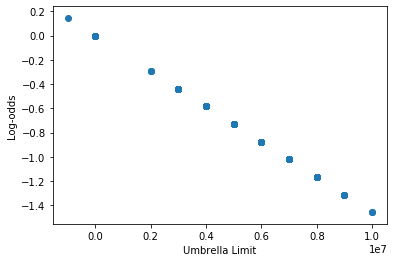

In [125]:
# Visual Check
logit_results = sm.GLM(y, X, family=sm.families.Binomial()).fit()

predicted = logit_results.predict(X)

# Getting log odds values
log_odds = np.log(predicted / (1 - predicted))

# Visualize predictor variable vs logit values for Age
plt.scatter(x=X_constant['umbrella_limit'].values, y=log_odds)
plt.xlabel("Umbrella Limit")
plt.ylabel("Log-odds")
plt.show()

### 2. Check for Assumption: Independence of observations

In [126]:
ins_clms['umbrella_limit'].unique()

array([       0,  5000000,  6000000,  4000000,  3000000,  8000000,
        7000000,  9000000, 10000000, -1000000,  2000000], dtype=int64)

### 3. Check for Assumption: Discrete Outcome

In [127]:
pd.Series([variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])], index=X_train.columns)

polcsl_250/500                     1.394606
High School                        1.214277
JD                                 1.227957
not-in-family                      1.210462
inctyp_Others                           inf
inctyp_Single Vehicle Collision    1.640875
colltyp_Unknown                         inf
incsev_Minor Damage                1.996468
incsev_Total Loss                  1.566959
incsev_Trivial Damage              2.415636
authcon_None                       2.161645
incst_WV                           1.263114
umbrella_limit                     1.020319
dtype: float64

In [128]:
# Lets drop inctyp_Others
X_train.drop('inctyp_Others', axis=1, inplace=True)
X_test.drop('inctyp_Others', axis=1, inplace=True)

In [129]:
# Check VIF again
pd.Series([variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])], index=X_train.columns)

polcsl_250/500                     1.394606
High School                        1.214277
JD                                 1.227957
not-in-family                      1.210462
inctyp_Single Vehicle Collision    1.640875
colltyp_Unknown                    4.333823
incsev_Minor Damage                1.996468
incsev_Total Loss                  1.566959
incsev_Trivial Damage              2.415636
authcon_None                       2.161645
incst_WV                           1.263114
umbrella_limit                     1.020319
dtype: float64

**VIFs are below 5. Lets train the model with these variables**

In [130]:
# Check X_train
X_train.head()

,polcsl_250/500,High School,JD,not-in-family,inctyp_Single Vehicle Collision,colltyp_Unknown,incsev_Minor Damage,incsev_Total Loss,incsev_Trivial Damage,authcon_None,incst_WV,umbrella_limit
541,1,0,1,0,0,1,0,0,1,0,0,2.581616
440,0,0,0,1,1,0,0,1,0,0,0,-0.477615
482,0,0,1,1,0,0,0,0,0,0,1,-0.477615
422,0,1,0,0,1,0,0,0,0,0,1,-0.477615
778,0,0,0,1,0,0,0,1,0,0,1,-0.477615


In [131]:
logm42 = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())
logm42.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      687
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -266.24
Date:                Thu, 23 Mar 2023   Deviance:                       532.48
Time:                        15:01:53   Pearson chi2:                     667.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.1375      0.224     -0.614      0.539      -0.577       0.302
polcsl_250/500                      0.4907      0.229      2.140      0.032       0.041       0.940
High School                         0.7129      0.311      2.289      0.022       0.102       1.323
JD                                  0.8583      0.300      2.859      0.004       0.270       1.447
not-in-family                       0.6193      0.293      2.111      0.035       0.044       1.194
inctyp_Single Vehicle Collision     0.6604      0.237      2.787      0.005       0.196       1.125
colltyp_Unknown                     1.7849      0.567      3.145      0.002       0.673       2.897
incsev_Minor Damage                -3.1643      0.325     -9.727      0.000      -3.802      -2.527
incsev_Total Loss                  -2.8213      0.293     -9.627      0.000      -3.396      -2.247
incsev_Trivial Damage              -5.4173      0.950     -5.704      0.000      -7.279      -3.556
authcon_None                       -1.7765      0.766     -2.318      0.020      -3.278      -0.275
incst_WV                           -0.7331      0.300     -2.447      0.014      -1.320      -0.146
umbrella_limit                      0.4736      0.107      4.437      0.000       0.264       0.683
===================================================================================================
"""

**We can consider the above model as the final model where all assumptions of Logistic Regression are met**

### Predict on Test Data

#### Using Logistic Regression from sklearn family

In [132]:
# X_train, X_test, y_train, y_test

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model = LogisticRegression(solver='liblinear', C=10.0, random_state=0)
model.fit(X_train, y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [133]:
p_pred = model.predict_proba(X_test)
y_pred = model.predict(X_test)

score_ = model.score(X_test, y_test)

In [134]:
score_

0.7533333333333333

In [135]:
conf_m = confusion_matrix(y_test, y_pred)

conf_m

array([[191,  29],
       [ 45,  35]], dtype=int64)

In [136]:
report = classification_report(y_test, y_pred)

report

'              precision    recall  f1-score   support\n\n           0       0.81      0.87      0.84       220\n           1       0.55      0.44      0.49        80\n\n    accuracy                           0.75       300\n   macro avg       0.68      0.65      0.66       300\nweighted avg       0.74      0.75      0.74       300\n'

In [137]:
# We can format to get the classification_report in a better visible way by using this function

def print_score(classifier, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = classifier.predict(X_train)
        classifier_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n--------------------------------------------")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{classifier_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = classifier.predict(X_test)
        classifier_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n---------------------------------------------")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{classifier_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [138]:
# On Test Dataset
print_score(model, X_train, y_train, X_test, y_test, train=False)

Test Result:
---------------------------------------------
Accuracy Score: 75.33%
_______________________________________________
Classification Report:
                    0          1  accuracy   macro avg  weighted avg
precision    0.809322   0.546875  0.753333    0.678099      0.739336
recall       0.868182   0.437500  0.753333    0.652841      0.753333
f1-score     0.837719   0.486111  0.753333    0.661915      0.743957
support    220.000000  80.000000  0.753333  300.000000    300.000000
_______________________________________________
Confusion Matrix: 
 [[191  29]
 [ 45  35]]



#### Using GLM from statsmodels family

In [139]:
# Using GLM model on train dataset

X_train_sm = sm.add_constant(X_train)
glm_model = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
result_train = glm_model.fit()
result_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  700
Model:                            GLM   Df Residuals:                      687
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -266.24
Date:                Thu, 23 Mar 2023   Deviance:                       532.48
Time:                        15:20:48   Pearson chi2:                     667.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.1375      0.224     -0.614      0.539      -0.577       0.302
polcsl_250/500                      0.4907      0.229      2.140      0.032       0.041       0.940
High School                         0.7129      0.311      2.289      0.022       0.102       1.323
JD                                  0.8583      0.300      2.859      0.004       0.270       1.447
not-in-family                       0.6193      0.293      2.111      0.035       0.044       1.194
inctyp_Single Vehicle Collision     0.6604      0.237      2.787      0.005       0.196       1.125
colltyp_Unknown                     1.7849      0.567      3.145      0.002       0.673       2.897
incsev_Minor Damage                -3.1643      0.325     -9.727      0.000      -3.802      -2.527
incsev_Total Loss                  -2.8213      0.293     -9.627      0.000      -3.396      -2.247
incsev_Trivial Damage              -5.4173      0.950     -5.704      0.000      -7.279      -3.556
authcon_None                       -1.7765      0.766     -2.318      0.020      -3.278      -0.275
incst_WV                           -0.7331      0.300     -2.447      0.014      -1.320      -0.146
umbrella_limit                      0.4736      0.107      4.437      0.000       0.264       0.683
===================================================================================================
"""

In [140]:
# Getting the predicted values on the train set
y_train_pred = result_train.predict(X_train_sm)
y_train_pred[:10]

541    0.231785
440    0.129510
482    0.594056
422    0.568660
778    0.035613
949    0.052991
334    0.217083
576    0.053775
934    0.661767
567    0.586412
dtype: float64

In [141]:
# Use GLM model on test Dataset

X_test_sm = sm.add_constant(X_test)
glm_model_test = sm.GLM(y_test,X_test_sm, family = sm.families.Binomial())
result_test = glm_model_test.fit()
result_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         fraud_reported   No. Observations:                  300
Model:                            GLM   Df Residuals:                      287
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -136.17
Date:                Thu, 23 Mar 2023   Deviance:                       272.35
Time:                        15:21:30   Pearson chi2:                     304.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.9044      0.327      2.765      0.006       0.263       1.545
polcsl_250/500                     -0.1613      0.323     -0.499      0.618      -0.795       0.472
High School                        -0.7567      0.483     -1.568      0.117      -1.703       0.189
JD                                 -0.3091      0.442     -0.699      0.484      -1.176       0.557
not-in-family                       0.0337      0.410      0.082      0.934      -0.769       0.837
inctyp_Single Vehicle Collision    -0.5293      0.329     -1.607      0.108      -1.175       0.116
colltyp_Unknown                    -1.4331      1.181     -1.214      0.225      -3.747       0.881
incsev_Minor Damage                -2.3131      0.404     -5.730      0.000      -3.104      -1.522
incsev_Total Loss                  -2.0800      0.397     -5.240      0.000      -2.858      -1.302
incsev_Trivial Damage              -1.3004      1.234     -1.054      0.292      -3.718       1.117
authcon_None                        0.0582      0.979      0.060      0.953      -1.860       1.977
incst_WV                           -0.2656      0.380     -0.699      0.484      -1.010       0.479
umbrella_limit                     -0.1406      0.165     -0.851      0.395      -0.464       0.183
===================================================================================================
"""

In [142]:
# Getting the predicted values on the test set
y_test_pred = result_test.predict(X_test_sm)
y_test_pred[:10]

521    0.115990
737    0.134101
740    0.145729
660    0.248157
411    0.066213
678    0.109265
626    0.667764
513    0.187069
859    0.248157
136    0.028432
dtype: float64